# Install Dependencies

In [116]:
%%capture
%pip install torch_geometric torch pandas wandb

In [117]:
import os
import shutil

# Create a directory in your Google Drive
workdir = os.getcwd() + "/DGT"

# Remove and recreate directory
if os.path.exists(workdir):
    shutil.rmtree(workdir)
os.makedirs(workdir)

# Dataset Construction

## Download Dataset

In [118]:
# Clone the repository to download the S&P500 stock prices, precomputed correlation matrcies,
# along with trained model weights for ease of evaluation
!git clone https://github.com/AlienKevin/sp500.git

import shutil
import os

repo_name = "sp500"
for file_name in os.listdir(repo_name):
    shutil.move(os.path.join(repo_name, file_name), workdir)

# Remove the cloned repository folder
shutil.rmtree(repo_name)

Cloning into 'sp500'...
remote: Enumerating objects: 125, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 125 (delta 0), reused 21 (delta 0), pack-reused 85 (from 1)
Receiving objects: 100% (125/125), 187.45 MiB | 28.78 MiB/s, done.
Updating files: 100% (99/99), done.


## Exploratory Data Analysis Shows Superiority of Mutual Information in Capturing Interstock Relationships

In [119]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Plot the 3 most correlated stocks to the target_stock based on corr_name with scope corr_scope
def plot_most_correlated_stocks(target_stock, corr_name, corr_scope):
    df = pd.read_csv(f'{workdir}/sp500.csv')
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')

    target_index = df.columns.get_loc(target_stock)

    corr = np.loadtxt(f'{workdir}/{corr_name}/{corr_scope}.csv', delimiter=',')

    top_3_correlated_indices = corr[target_index].argsort()[-4:][::-1]
    top_3_correlated_stocks = df.columns[top_3_correlated_indices]

    plt.clf()
    plt.figure(figsize=(12, 6))
    plt.style.use('default')

    for stock in top_3_correlated_stocks:
        if corr_scope.startswith('global'):
            # Plot the entire duration of the dataset for global correlations
            plt.plot(df.index, df[stock], label=stock)
        else:
            # Only plot the time window corresponding to the local correlations
            num_days_in_quarter = 64
            quarter_index = int(corr_scope.split('_')[-1])
            quarter_start_index = quarter_index * num_days_in_quarter
            quarter_end_index = (quarter_index + 1) * num_days_in_quarter
            print('Quarter Start date', df.index[quarter_start_index])
            print('Quarter End date', df.index[quarter_end_index])
            quarter_df = df.iloc[quarter_start_index:quarter_end_index]
            plt.plot(quarter_df.index, quarter_df[stock], label=stock)

    plt.title(f"Top 3 Correlated Stocks with {top_3_correlated_stocks[0]} using {'Global' if corr_scope.startswith('global') else 'Local'} {'Pearson' if corr_name == 'pcc' else 'Mutual Information'}: {', '.join(top_3_correlated_stocks[1:])}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()


## Global Mutual Information Captures Shared Trends Well

<Figure size 640x480 with 0 Axes>

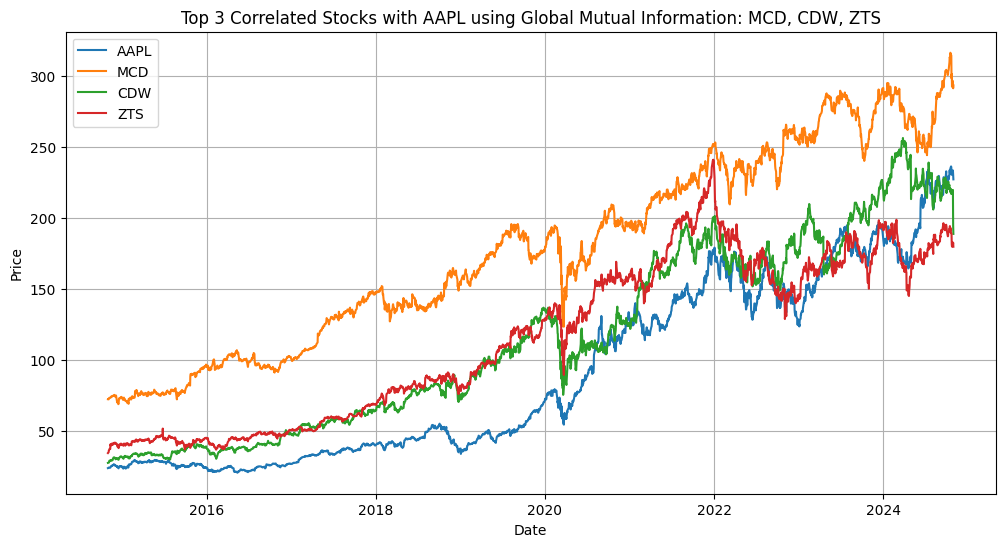

In [120]:
plot_most_correlated_stocks('AAPL', 'mi', 'global_corr')

## Global Pearson Struggles with Nonlinearity in the Market

<Figure size 640x480 with 0 Axes>

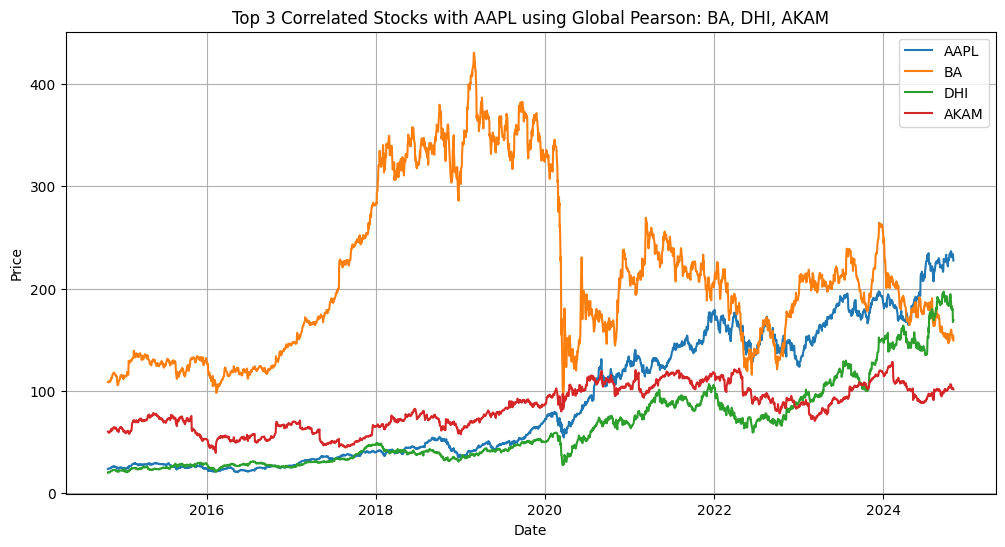

In [121]:
plot_most_correlated_stocks('AAPL', 'pcc', 'global_corr')

## Mutual Information and Pearson Perform Similarly Well on a Local Scope (the Length of 1 Fiscal Quarter)

Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00
Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00
Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00
Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00


<Figure size 640x480 with 0 Axes>

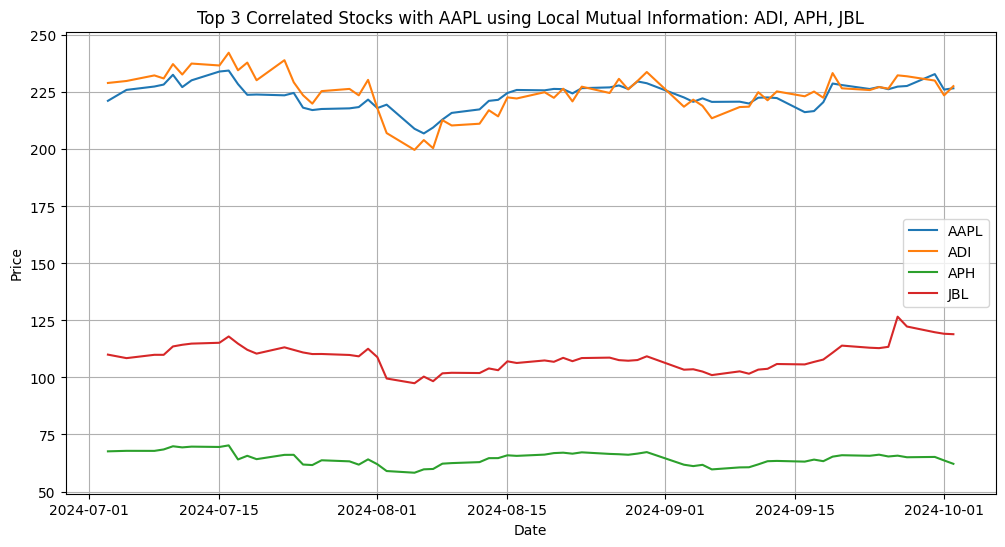

In [122]:
plot_most_correlated_stocks('AAPL', 'mi', 'local_corr_38')

Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00
Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00
Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00
Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00


<Figure size 640x480 with 0 Axes>

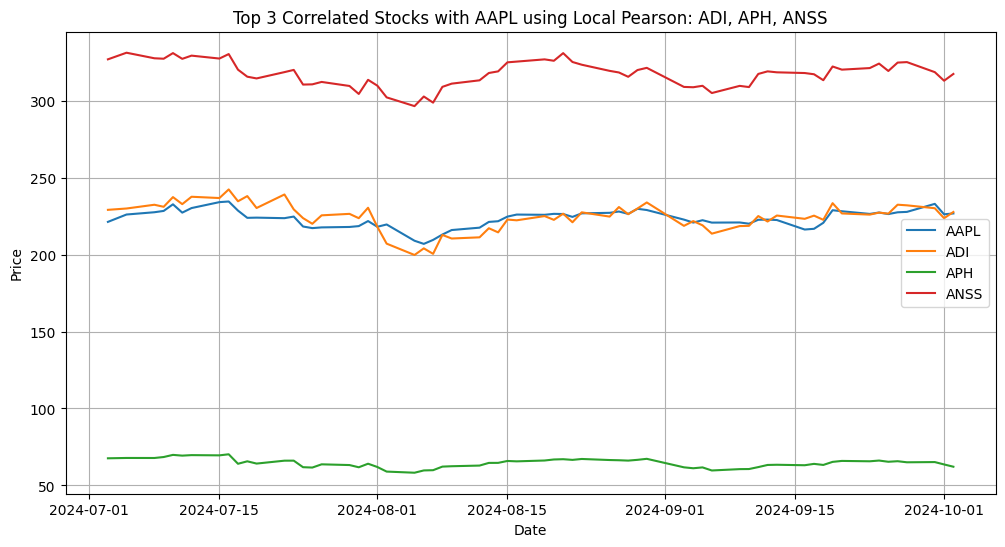

In [123]:
plot_most_correlated_stocks('AAPL', 'pcc', 'local_corr_38')

## Construct Temporal PyG Dataset

In [124]:
# Copied from PyG temporal rather than imported because the library has dependency issues with PyG
# https://pytorch-geometric-temporal.readthedocs.io/en/latest/_modules/torch_geometric_temporal/signal/dynamic_graph_temporal_signal.html

from typing import Sequence, Union
import numpy as np
import torch
from torch_geometric.data import Data


Edge_Indices = Sequence[Union[np.ndarray, None]]
Edge_Weights = Sequence[Union[np.ndarray, None]]
Node_Features = Sequence[Union[np.ndarray, None]]
Targets = Sequence[Union[np.ndarray, None]]
Additional_Features = Sequence[np.ndarray]

class DynamicGraphTemporalSignal(object):
    r"""A data iterator object to contain a dynamic graph with a
    changing edge set and weights . The feature set and node labels
    (target) are also dynamic. The iterator returns a single discrete temporal
    snapshot for a time period (e.g. day or week). This single snapshot is a
    Pytorch Geometric Data object. Between two temporal snapshots the edges,
    edge weights, target matrices and optionally passed attributes might change.

    Args:
        edge_indices (Sequence of Numpy arrays): Sequence of edge index tensors.
        edge_weights (Sequence of Numpy arrays): Sequence of edge weight tensors.
        features (Sequence of Numpy arrays): Sequence of node feature tensors.
        targets (Sequence of Numpy arrays): Sequence of node label (target) tensors.
        **kwargs (optional Sequence of Numpy arrays): Sequence of additional attributes.
    """

    def __init__(
        self,
        edge_indices: Edge_Indices,
        edge_weights: Edge_Weights,
        features: Node_Features,
        targets: Targets,
        **kwargs: Additional_Features
    ):
        self.edge_indices = edge_indices
        self.edge_weights = edge_weights
        self.features = features
        self.targets = targets
        self.additional_feature_keys = []
        for key, value in kwargs.items():
            setattr(self, key, value)
            self.additional_feature_keys.append(key)
        self._check_temporal_consistency()
        self._set_snapshot_count()

    def _check_temporal_consistency(self):
        assert len(self.features) == len(
            self.targets
        ), "Temporal dimension inconsistency."
        assert len(self.edge_indices) == len(
            self.edge_weights
        ), "Temporal dimension inconsistency."
        assert len(self.features) == len(
            self.edge_weights
        ), "Temporal dimension inconsistency."
        for key in self.additional_feature_keys:
            assert len(self.targets) == len(
                getattr(self, key)
            ), "Temporal dimension inconsistency."

    def _set_snapshot_count(self):
        self.snapshot_count = len(self.features)

    def _get_edge_index(self, time_index: int):
        if self.edge_indices[time_index] is None:
            return self.edge_indices[time_index]
        else:
            return torch.LongTensor(self.edge_indices[time_index])

    def _get_edge_weight(self, time_index: int):
        if self.edge_weights[time_index] is None:
            return self.edge_weights[time_index]
        else:
            return torch.FloatTensor(self.edge_weights[time_index])

    def _get_features(self, time_index: int):
        if self.features[time_index] is None:
            return self.features[time_index]
        else:
            return torch.FloatTensor(self.features[time_index])

    def _get_target(self, time_index: int):
        if self.targets[time_index] is None:
            return self.targets[time_index]
        else:
            if self.targets[time_index].dtype.kind == "i":
                return torch.LongTensor(self.targets[time_index])
            elif self.targets[time_index].dtype.kind == "f":
                return torch.FloatTensor(self.targets[time_index])

    def _get_additional_feature(self, time_index: int, feature_key: str):
        feature = getattr(self, feature_key)[time_index]
        if feature.dtype.kind == "i":
            return torch.LongTensor(feature)
        elif feature.dtype.kind == "f":
            return torch.FloatTensor(feature)

    def _get_additional_features(self, time_index: int):
        additional_features = {
            key: self._get_additional_feature(time_index, key)
            for key in self.additional_feature_keys
        }
        return additional_features

    def __getitem__(self, time_index: Union[int, slice]):
        if isinstance(time_index, slice):
            snapshot = DynamicGraphTemporalSignal(
                self.edge_indices[time_index],
                self.edge_weights[time_index],
                self.features[time_index],
                self.targets[time_index],
                **{key: getattr(self, key)[time_index] for key in self.additional_feature_keys}
            )
        else:
            x = self._get_features(time_index)
            edge_index = self._get_edge_index(time_index)
            edge_weight = self._get_edge_weight(time_index)
            y = self._get_target(time_index)
            additional_features = self._get_additional_features(time_index)

            snapshot = Data(x=x, edge_index=edge_index, edge_attr=edge_weight,
                            y=y, **additional_features)
        return snapshot

    def __next__(self):
        if self.t < len(self.features):
            snapshot = self[self.t]
            self.t = self.t + 1
            return snapshot
        else:
            self.t = 0
            raise StopIteration

    def __iter__(self):
        self.t = 0
        return self

In [125]:
# Copied from PyG temporal rather than imported because the library has dependency issues with PyG
# https://pytorch-geometric-temporal.readthedocs.io/en/latest/_modules/torch_geometric_temporal/signal/static_graph_temporal_signal.html#StaticGraphTemporalSignal
import torch
import numpy as np
from typing import Sequence, Union
from torch_geometric.data import Data


Edge_Index = Union[np.ndarray, None]
Edge_Weight = Union[np.ndarray, None]
Node_Features = Sequence[Union[np.ndarray, None]]
Targets = Sequence[Union[np.ndarray, None]]
Additional_Features = Sequence[np.ndarray]

class StaticGraphTemporalSignal(object):
    r"""A data iterator object to contain a static graph with a dynamically
    changing constant time difference temporal feature set (multiple signals).
    The node labels (target) are also temporal. The iterator returns a single
    constant time difference temporal snapshot for a time period (e.g. day or week).
    This single temporal snapshot is a Pytorch Geometric Data object. Between two
    temporal snapshots the features and optionally passed attributes might change.
    However, the underlying graph is the same.

    Args:
        edge_index (Numpy array): Index tensor of edges.
        edge_weight (Numpy array): Edge weight tensor.
        features (Sequence of Numpy arrays): Sequence of node feature tensors.
        targets (Sequence of Numpy arrays): Sequence of node label (target) tensors.
        **kwargs (optional Sequence of Numpy arrays): Sequence of additional attributes.
    """

    def __init__(
        self,
        edge_index: Edge_Index,
        edge_weight: Edge_Weight,
        features: Node_Features,
        targets: Targets,
        **kwargs: Additional_Features
    ):
        self.edge_index = edge_index
        self.edge_weight = edge_weight
        self.features = features
        self.targets = targets
        self.additional_feature_keys = []
        for key, value in kwargs.items():
            setattr(self, key, value)
            self.additional_feature_keys.append(key)
        self._check_temporal_consistency()
        self._set_snapshot_count()

    def _check_temporal_consistency(self):
        assert len(self.features) == len(
            self.targets
        ), "Temporal dimension inconsistency."
        for key in self.additional_feature_keys:
            assert len(self.targets) == len(
                getattr(self, key)
            ), "Temporal dimension inconsistency."

    def _set_snapshot_count(self):
        self.snapshot_count = len(self.features)

    def _get_edge_index(self):
        if self.edge_index is None:
            return self.edge_index
        else:
            return torch.LongTensor(self.edge_index)

    def _get_edge_weight(self):
        if self.edge_weight is None:
            return self.edge_weight
        else:
            return torch.FloatTensor(self.edge_weight)

    def _get_features(self, time_index: int):
        if self.features[time_index] is None:
            return self.features[time_index]
        else:
            return torch.FloatTensor(self.features[time_index])

    def _get_target(self, time_index: int):
        if self.targets[time_index] is None:
            return self.targets[time_index]
        else:
            if self.targets[time_index].dtype.kind == "i":
                return torch.LongTensor(self.targets[time_index])
            elif self.targets[time_index].dtype.kind == "f":
                return torch.FloatTensor(self.targets[time_index])

    def _get_additional_feature(self, time_index: int, feature_key: str):
        feature = getattr(self, feature_key)[time_index]
        if feature.dtype.kind == "i":
            return torch.LongTensor(feature)
        elif feature.dtype.kind == "f":
            return torch.FloatTensor(feature)

    def _get_additional_features(self, time_index: int):
        additional_features = {
            key: self._get_additional_feature(time_index, key)
            for key in self.additional_feature_keys
        }
        return additional_features

    def __getitem__(self, time_index: Union[int, slice]):
        if isinstance(time_index, slice):
            snapshot = StaticGraphTemporalSignal(
                self.edge_index,
                self.edge_weight,
                self.features[time_index],
                self.targets[time_index],
                **{key: getattr(self, key)[time_index] for key in self.additional_feature_keys}
            )
        else:
            x = self._get_features(time_index)
            edge_index = self._get_edge_index()
            edge_weight = self._get_edge_weight()
            y = self._get_target(time_index)
            additional_features = self._get_additional_features(time_index)

            snapshot = Data(x=x, edge_index=edge_index, edge_attr=edge_weight,
                            y=y, **additional_features)
        return snapshot

    def __next__(self):
        if self.t < len(self.features):
            snapshot = self[self.t]
            self.t = self.t + 1
            return snapshot
        else:
            self.t = 0
            raise StopIteration

    def __iter__(self):
        self.t = 0
        return self

In [126]:
import numpy as np
import pandas as pd
import torch
from typing import Union
import glob
from natsort import natsorted
import random

# Fix random seed for ease of reproduction
seed = 42
random.seed(seed)
torch.manual_seed(seed)

# Dataset loader for SP500 stock prices
class SP500CorrelationsDatasetLoader(object):
    def __init__(self, corr_name, corr_scope, multitask=False, vol_horizon=5):
        """
        Args:
            corr_name: Name of correlation type ('pcc', 'mi', etc.)
            corr_scope: Scope of correlation ('global', 'local', 'dual', None)
            multitask: If True, generate volatility targets alongside price targets
            vol_horizon: Number of days for future volatility calculation
        """
        self.multitask = multitask
        self.vol_horizon = vol_horizon
        self._read_csv(corr_name, corr_scope)

    # Load a global correlation under the name corr_name
    def _load_global_corr(self, corr_name):
        return np.loadtxt(f'{workdir}/{corr_name}/global_corr.csv', delimiter=',')

    # Load a local correlation under the name corr_name
    def _load_local_corrs(self, corr_name):
        _correlation_matrices = []
        corr_files = natsorted(glob.glob(f'{workdir}/{corr_name}/local_corr_*.csv'))
        for corr_file in corr_files:
            matrix = np.loadtxt(corr_file, delimiter=',')
            _correlation_matrices.append(matrix)
        return _correlation_matrices

    # Helper function for reading a correlation with type corr_name and scope corr_scope from CSV file
    def _read_csv(self, corr_name, corr_scope):
        match corr_scope:
            case 'global':
                self._correlation_matrices = [self._load_global_corr(corr_name)]
            case 'local':
                self._correlation_matrices = self._load_local_corrs(corr_name)
            case 'dual':
                # Stack global and local correlation matrices for dual correlation
                global_corr = self._load_global_corr(corr_name)
                self._correlation_matrices = [np.stack((global_corr, local_corr), axis=-1) for local_corr in self._load_local_corrs(corr_name)]
            case None:
                # None uses identity matrix as correlation
                # Infer dimension from a global correlation matrix
                global_corr = self._load_global_corr('pcc')
                self._correlation_matrices = [np.eye(global_corr.shape[0], global_corr.shape[1])]

        if corr_name == 'mi':
            # Normalize MI to [0, 1]
            max_mi = 0
            for matrix in self._correlation_matrices:
                max_mi = max(np.max(matrix), max_mi)
                # MI shouldn't be negative
                matrix[matrix < 0] = 0
            for matrix in self._correlation_matrices:
                matrix = matrix / max_mi

        df = pd.read_csv(f'{workdir}/sp500.csv')
        df = df.set_index('Date')
        data = torch.from_numpy(df.to_numpy()).to(torch.float32)

        # Round data size to nearest multiple of batch_size
        self.days_in_quarter = 64
        num_quarters = data.size(0) // self.days_in_quarter
        num_days = num_quarters * self.days_in_quarter
        data = data[:num_days]

        # Store raw data for volatility computation before normalization
        self._raw_data = data.numpy().copy()

        # z-score normalization with training data following GERU
        train_days = int(0.8 * num_quarters) * self.days_in_quarter
        self._train_mean = data[:train_days].mean(dim=0)
        self._train_std = data[:train_days].std(dim=0)
        data = (data - self._train_mean) / self._train_std
        data = data.numpy()

        if self.multitask:
            # Compute historical volatility as additional feature
            # This gives the model direct access to past volatility patterns
            hist_vol = self._historical_vol_from_prices(self._raw_data, self.vol_horizon)
            # Normalize historical volatility
            hist_vol_train = hist_vol[:train_days]
            self._hist_vol_mean = np.mean(hist_vol_train)
            self._hist_vol_std = np.std(hist_vol_train) + 1e-8
            hist_vol_norm = (hist_vol - self._hist_vol_mean) / self._hist_vol_std
            # Stack price and historical volatility as 2 input features
            data = np.stack([data, hist_vol_norm], axis=-1)  # (T, N, 2)
        else:
            data = data[..., np.newaxis]  # (T, N, 1)

        assert(not np.any(np.isnan(data)))
        self._dataset = data

    @staticmethod
    def _future_vol_from_prices(prices, horizon=5):
        """
        Compute realized volatility over a future window.
        Args:
            prices: numpy array of shape (T, N) - raw prices
            horizon: number of days for volatility window
        Returns:
            vol: numpy array of shape (T - horizon, N) - realized volatility
        """
        T, N = prices.shape
        # Use log returns for volatility
        log_returns = np.log(prices[1:] / prices[:-1] + 1e-8)
        vol = np.zeros((T - horizon, N))
        for t in range(T - horizon):
            vol[t] = np.std(log_returns[t:t+horizon], axis=0)
        return vol

    @staticmethod
    def _historical_vol_from_prices(prices, horizon=5):
        """
        Compute historical (backward-looking) volatility as input feature.
        Args:
            prices: numpy array of shape (T, N) - raw prices
            horizon: number of days for volatility window
        Returns:
            vol: numpy array of shape (T, N) - historical volatility (padded at start)
        """
        T, N = prices.shape
        log_returns = np.log(prices[1:] / prices[:-1] + 1e-8)
        vol = np.zeros((T, N))
        for t in range(horizon, T):
            vol[t] = np.std(log_returns[t-horizon:t], axis=0)
        # For first 'horizon' days, use average of what we have
        for t in range(1, horizon):
            vol[t] = np.std(log_returns[:t], axis=0) if t > 1 else log_returns[0]
        return vol

    def _get_edges(self, times, overlap):
        # Construct a fully-connected graph
        def helper(corr_index):
            return np.array(np.ones(self._correlation_matrices[corr_index].shape[:2]).nonzero())

        if len(self._correlation_matrices) == 1:
            _edges = helper(0)
        else:
            _edges = []
            for time in range(0, self._dataset.shape[0] - self.batch_size, overlap):
                if not time in times:
                    continue
                corr_index = max(0, time // self.days_in_quarter - 1)
                _edges.append(
                    helper(corr_index)
                )
        return _edges

    def _get_edge_weights(self, times, overlap):
        # Edge weights are the correlations between stocks
        def helper(corr_index):
            w = self._correlation_matrices[corr_index]
            # Flatten the first two dimensions
            return w.reshape((w.shape[0] * w.shape[1],) + w.shape[2:])

        if len(self._correlation_matrices) == 1:
            _edge_weights = helper(0)
        else:
            _edge_weights = []
            for time in range(0, self._dataset.shape[0] - self.batch_size, overlap):
                if not time in times:
                    continue
                corr_index = max(0, time // self.days_in_quarter - 1)
                _edge_weights.append(
                    helper(corr_index)
                )
        return _edge_weights

    def _get_targets_and_features(self, times, overlap, predict_all):
        # Given previous batch_size stock prices...
        features = [
            self._dataset[i : i + self.batch_size, :]
            for i in range(0, self._dataset.shape[0] - self.batch_size, overlap)
            if i in times
        ]
        
        if not self.multitask:
            # Single task: predict next-day stock prices only
            targets = [
                (self._dataset[i+1 : i + self.batch_size+1, :, 0]).T if predict_all else (self._dataset[i + self.batch_size, :, 0]).T
                for i in range(0, self._dataset.shape[0] - self.batch_size, overlap)
                if i in times
            ]
        else:
            # Multi-task: predict (price, volatility)
            # Compute future volatility from raw prices
            vol_all = self._future_vol_from_prices(self._raw_data, self.vol_horizon)
            # Normalize volatility with training stats
            vol_train_end = int(0.8 * (self._dataset.shape[0] // self.days_in_quarter)) * self.days_in_quarter
            vol_mean = np.mean(vol_all[:vol_train_end])
            vol_std = np.std(vol_all[:vol_train_end]) + 1e-8
            vol_all_norm = (vol_all - vol_mean) / vol_std
            
            targets = []
            for i in range(0, self._dataset.shape[0] - self.batch_size, overlap):
                if i not in times:
                    continue
                if predict_all:
                    # Many-to-many: predict all time steps
                    price_target = (self._dataset[i+1 : i + self.batch_size+1, :, 0]).T
                    vol_end_idx = min(i + self.batch_size, len(vol_all_norm))
                    vol_start_idx = i
                    if vol_end_idx - vol_start_idx == self.batch_size:
                        vol_target = vol_all_norm[vol_start_idx:vol_end_idx].T
                    else:
                        vol_target = np.zeros_like(price_target)
                        valid_len = vol_end_idx - vol_start_idx
                        vol_target[:, :valid_len] = vol_all_norm[vol_start_idx:vol_end_idx].T
                    target = np.stack([price_target, vol_target], axis=-1)
                else:
                    # Many-to-one: predict single time step
                    price_target = (self._dataset[i + self.batch_size, :, 0]).T
                    vol_idx = min(i + self.batch_size - 1, len(vol_all_norm) - 1)
                    vol_target = vol_all_norm[vol_idx] if vol_idx >= 0 else np.zeros_like(price_target)
                    target = np.stack([price_target, vol_target], axis=-1)
                targets.append(target)
        
        return features, targets

    def get_dataset(self, batch_size, split) -> Union[StaticGraphTemporalSignal, DynamicGraphTemporalSignal]:
        # Returning the data iterator where the train is designed for many-to-many predictions (each day predict next day's price)
        # while the validation and test are many-to-one predictions (many past days predict tomorrow's price)

        self.batch_size = batch_size

        total_times = list(range(0, self._dataset.shape[0] - self.batch_size, self.batch_size))

        # We do a 8-1-1 split for train-validation-test. Since the test set is one year apart from training,
        # It is much more challenging to predict.
        if split == 'train':
            times = list(range(total_times[int(len(total_times) * 0)], total_times[int(len(total_times) * 0.8)]))
            overlap = self.batch_size
            predict_all = True
        elif split == 'val':
            times = list(range(total_times[int(len(total_times) * 0.8)], total_times[int(len(total_times) * 0.9)]))
            overlap = 1
            predict_all = False
        elif split == 'test':
            times = list(range(total_times[int(len(total_times) * 0.9)], total_times[-1] + self.batch_size))
            overlap = 1
            predict_all = False
        else:
            raise ValueError(f'Invalid split name: {split}')

        _edges = self._get_edges(times, overlap)
        _edge_weights = self._get_edge_weights(times, overlap)
        features, targets = self._get_targets_and_features(times, overlap, predict_all)
        dataset = (DynamicGraphTemporalSignal if type(_edges) == list else StaticGraphTemporalSignal)(
            _edges, _edge_weights, features, targets
        )
        return dataset

In [127]:
# Helper function to get the dataset for a correlation
def get_dataset(corr_name, corr_scope, multitask=False, vol_horizon=5):
    """
    Get train/val/test datasets.
    
    Args:
        corr_name: Correlation type ('pcc', 'mi', etc.)
        corr_scope: Correlation scope ('global', 'local', 'dual', None)
        multitask: If True, include volatility targets alongside price targets
        vol_horizon: Number of days for future volatility calculation
    
    Returns:
        dict with train_samples, val_samples, test_samples
    """
    loader = SP500CorrelationsDatasetLoader(
        corr_name=corr_name, 
        corr_scope=corr_scope,
        multitask=multitask,
        vol_horizon=vol_horizon
    )

    lag_size = 64
    # Train dataset has double the batch_size because it's trained under many-to-many prediction.
    # During test time, the model is used for many-to-one prediction given batch_size previous days.
    # Hence, we need to have a larger training batch_size than the lag_size during test.
    train_dataset = loader.get_dataset(batch_size=lag_size * 2, split='train')
    val_dataset = loader.get_dataset(batch_size=lag_size, split='val')
    test_dataset = loader.get_dataset(batch_size=lag_size, split='test')

    train_samples = list(train_dataset)
    val_samples = list(val_dataset)
    test_samples = list(test_dataset)

    return {
        'train_samples': train_samples,
        'val_samples': val_samples,
        'test_samples': test_samples,
    }

# Differential Graph Transformer

In [128]:
# Adapted from reference implementation of Differential Transformer, included an optional A input to MultiheadDiffAttn.forward()
# https://github.com/microsoft/unilm/blob/master/Diff-Transformer/multihead_diffattn.py

import math
import torch
import torch.nn.functional as F
from torch import nn

class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6, elementwise_affine=True):
        super().__init__()
        self.dim = dim
        self.eps = eps
        self.elementwise_affine = elementwise_affine
        if self.elementwise_affine:
            self.weight = nn.Parameter(torch.ones(dim))
        else:
            self.register_parameter('weight', None)

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(x.float()).type_as(x)
        if self.weight is not None:
            output = output * self.weight
        return output

    def extra_repr(self) -> str:
        return f'dim={self.dim}, eps={self.eps}, elementwise_affine={self.elementwise_affine}'


def init_method(tensor, **kwargs):
    nn.init.kaiming_uniform_(tensor, a=math.sqrt(5))

def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    """torch.repeat_interleave(x, dim=1, repeats=n_rep)"""
    bs, n_kv_heads, slen, head_dim = x.shape
    if n_rep == 1:
        return x
    return (
        x[:, :, None, :, :]
        .expand(bs, n_kv_heads, n_rep, slen, head_dim)
        .reshape(bs, n_kv_heads * n_rep, slen, head_dim)
    )

def lambda_init_fn(depth):
    return 0.8 - 0.6 * math.exp(-0.3 * depth)


# Differential Graph Attention with multiple heads
class MultiheadDiffAttn(nn.Module):
    def __init__(
        self,
        embed_dim,
        depth,
        num_heads,
    ):
        super().__init__()
        self.embed_dim = embed_dim
        # num_heads set to half of Transformer's #heads
        self.num_heads = num_heads
        self.num_kv_heads = num_heads
        self.n_rep = self.num_heads // self.num_kv_heads

        self.head_dim = embed_dim // num_heads // 2
        self.scaling = self.head_dim ** -0.5

        self.q_proj = nn.Linear(embed_dim, embed_dim, bias=False)
        self.k_proj = nn.Linear(embed_dim, embed_dim // self.n_rep, bias=False)
        self.v_proj = nn.Linear(embed_dim, embed_dim // self.n_rep, bias=False)

        self.lambda_init = lambda_init_fn(depth)
        self.lambda_q1 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0,std=0.1))
        self.lambda_k1 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0,std=0.1))
        self.lambda_q2 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0,std=0.1))
        self.lambda_k2 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0,std=0.1))

        self.subln = RMSNorm(2 * self.head_dim, eps=1e-5, elementwise_affine=True)

    def forward(
        self,
        x,
        A=None,
        attn_mask=None,
    ):
        bsz, tgt_len, embed_dim = x.size()
        src_len = tgt_len

        # Project input x into query, key, and value
        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)

        q = q.view(bsz, tgt_len, 2 * self.num_heads, self.head_dim)
        k = k.view(bsz, src_len, 2 * self.num_kv_heads, self.head_dim)
        v = v.view(bsz, src_len, self.num_kv_heads, 2 * self.head_dim)

        q = q.transpose(1, 2)
        k = repeat_kv(k.transpose(1, 2), self.n_rep)
        v = repeat_kv(v.transpose(1, 2), self.n_rep)
        q *= self.scaling

        # Compute attention weights by multiplying query and key
        attn_weights = torch.matmul(q, k.transpose(-1, -2))
        attn_weights = torch.nan_to_num(attn_weights)
        # Apply attention mask
        if attn_mask is not None:
            attn_weights += attn_mask
        # Calculate attention scores using softmax
        attn_weights = F.softmax(attn_weights, dim=-1, dtype=torch.float32).type_as(
            attn_weights
        )

        # Calculate the lambda used for differential attention
        lambda_1 = torch.exp(torch.sum(self.lambda_q1 * self.lambda_k1, dim=-1).float()).type_as(q)
        lambda_2 = torch.exp(torch.sum(self.lambda_q2 * self.lambda_k2, dim=-1).float()).type_as(q)
        lambda_full = lambda_1 - lambda_2 + self.lambda_init

        # Optionally condition the differential attention on a graph prior A
        attn_weights = attn_weights.view(bsz, self.num_heads, 2, tgt_len, src_len)
        attn_weights = attn_weights[:, :, 0] * (1 if A is None else A) - lambda_full * attn_weights[:, :, 1]

        # Compute output embeddings by mixing values based on their attention scores
        attn = torch.matmul(attn_weights, v)
        attn = self.subln(attn)
        attn = attn * (1 - self.lambda_init)
        attn = attn.transpose(1, 2).reshape(bsz, tgt_len, self.num_heads * 2 * self.head_dim)
        
        # Store the last attention weights for visualization
        self.last_attn = attn_weights.detach()
        
        return (attn, attn_weights)


In [129]:
import torch
import torch.nn as nn
from torch_geometric.utils import to_dense_adj

# A normal feedforward layer
class FeedForward(nn.Module):
    def __init__(self, hidden_size, expand_ratio, dropout):
        super(FeedForward, self).__init__()
        self.linear = nn.Linear(hidden_size, hidden_size * expand_ratio)
        self.linear2 = nn.Linear(hidden_size * expand_ratio, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.dropout(x)
        return x

# Wrapper code for MultiheadDiffAttn with layer norm and feedforward after the attention
class Attention(nn.Module):
    def __init__(self, d_model, num_heads, expand_ratio, dropout):
        super().__init__()
        self.mha = MultiheadDiffAttn(embed_dim=d_model, num_heads=num_heads, depth=0)
        self.ln2 = nn.LayerNorm(d_model)
        self.ffn = FeedForward(hidden_size=d_model, expand_ratio=expand_ratio, dropout=dropout)

    def forward(self, x, A=None, attn_mask=None, need_weights=False):
        x1, attn_weights = self.mha(x, A, attn_mask=attn_mask)
        x = self.ln2(self.ffn(x1) + x1)
        if need_weights:
            return (x, attn_weights)
        else:
            return x

# Differential Graph Transformer = temporal attention + spatial attention
# Spatial attention may optionally receive an adjacency matrix for conditioning.
class DGT(nn.Module):
    def __init__(self, in_channels=1, out_channels=32, num_heads=2, num_layers=2, expand_ratio=1, dropout=0.1, T=128, N=472, use_spatial=True):
        super().__init__()
        self.T = T
        self.N = N
        self.d_model = out_channels
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.input_proj = nn.Linear(in_channels, out_channels)
        self.time_embedding = nn.Embedding(T, out_channels)
        self.stock_embedding = nn.Embedding(N, out_channels)
        self.use_spatial = use_spatial
        if use_spatial:
            self.spatial_attns = nn.ModuleList([Attention(out_channels, num_heads, expand_ratio, dropout) for _ in range(num_layers)])
        self.temporal_attns = nn.ModuleList([Attention(out_channels, num_heads, expand_ratio, dropout) for _ in range(num_layers)])

    def forward(self, x, edge_index, edge_weight, need_weights=False):
        N, T, D = x.size()
        assert(D == self.input_proj.in_features)  # D must match in_channels
        assert(T <= self.T and N == self.N)

        # Compute initial node embedding for the graph transformer
        # Node embedding incorporates current stock prices, stock embeddings, and time embeddings.
        x = x.permute(1, 0, 2) # T, N, D
        x = self.input_proj(x)
        stock_embs = self.stock_embedding(torch.arange(N).unsqueeze(0).expand(T, N).to(x.device))
        x += stock_embs
        time_embs = self.time_embedding(torch.arange(T).unsqueeze(0).expand(N, T).to(x.device))
        x += time_embs.permute(1, 0, 2) # T, N, D

        x = x.permute(1, 0, 2) # N, T, D

        # Iterate through each layer of DGT
        for i in range(self.num_layers):
            # First apply temporal attention to learn temporal dependencies
            temporal_causal_mask = torch.triu(
                torch.zeros([T, T])
                    .float()
                    .fill_(float("-inf")),
                    1,
                ).expand(N, self.num_heads*2, T, T).to(x.device)
            x = self.temporal_attns[i](x, attn_mask=temporal_causal_mask, need_weights=need_weights) + x

            # Next apply spatial attention (aka differential graph attention) to learn interstock relations
            if self.use_spatial:
                x = x.permute(1, 0, 2) # T, N, D
                A = to_dense_adj(edge_index, edge_attr=edge_weight)
                # Encountered more than one adjacency matrices, e.g. dual correlations
                if len(A.size()) == 4:
                    A = A.reshape(A.size(-1), A.size(1), A.size(2))
                x = self.spatial_attns[i](x, A, need_weights=need_weights) + x
                x = x.permute(1, 0, 2) # N, T, D

        return x

# GRU Baseline

In [130]:
# Gated Recurrent Unit baseline for comparison
class GRU(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int, num_layers: int):
        super(GRU, self).__init__()
        self.rnn = nn.GRU(input_size=in_channels, hidden_size=out_channels, num_layers=num_layers, batch_first=True)

    def forward(
        self,
        x: torch.FloatTensor,
        edge_index: torch.LongTensor,
        edge_weight: torch.FloatTensor = None,
    ) -> torch.FloatTensor:
        outputs, _ = self.rnn(x)
        return outputs

# Driver

In [131]:
import torch
import torch.nn.functional as F

# Common driver for all models
class Driver(torch.nn.Module):
    def __init__(self, gnn, corr_name, corr_scope, node_features, hidden_size=32, multitask=False, **kwargs):
        """
        Args:
            gnn: Graph neural network class (DGT or GRU)
            corr_name: Correlation type name
            corr_scope: Correlation scope
            node_features: Number of input features per node
            hidden_size: Hidden dimension size
            multitask: If True, output both price (alpha) and volatility (sigma)
        """
        super(Driver, self).__init__()
        self.recurrent = gnn(in_channels=node_features, out_channels=hidden_size, **kwargs)
        self.multitask = multitask
        self.corr_name = corr_name
        self.corr_scope = corr_scope
        
        if multitask:
            # Dual heads for multi-task learning: price (alpha) and volatility (sigma)
            self.alpha_head = torch.nn.Linear(hidden_size, 1)  # Price prediction
            
            # MLP head for volatility - more capacity to learn different patterns
            # The volatility has different dynamics than price, needs deeper network
            self.sigma_head = torch.nn.Sequential(
                torch.nn.Linear(hidden_size, hidden_size),
                torch.nn.ReLU(),
                torch.nn.Linear(hidden_size, hidden_size // 2),
                torch.nn.ReLU(),
                torch.nn.Linear(hidden_size // 2, 1)
            )
        else:
            # Single head for price prediction only
            self.linear = torch.nn.Linear(hidden_size, 1)

    # Run on the provided graph (specified with edge_index and edge_weight) and temporal signal x (past stock prices)
    def forward(self, x, edge_index, edge_weight, hidden=None):
        device = self.model_device()
        if hidden is None:
            outputs = self.recurrent(x.to(device), edge_index.to(device), edge_weight.to(device))
        else:
            outputs = self.recurrent(x.to(device), edge_index.to(device), edge_weight.to(device), hidden)
        
        if self.multitask:
            # Dual output: (alpha, sigma)
            h = F.relu(outputs)
            alpha = self.alpha_head(h)      # (N, T, 1) - price prediction
            sigma = self.sigma_head(h)      # (N, T, 1) - volatility (z-score normalized)
            # Concatenate: (N, T, 2)
            return torch.cat([alpha, sigma], dim=-1), outputs
        else:
            # Single output: price only
            return self.linear(F.relu(outputs)), outputs

    # Get the model name for display and saving model weights
    def model_name(self):
        arch = self.model_arch()
        if arch == 'GRU':
            name = f'{arch}'
        elif arch == 'DGT':
            name = f'{arch}{"" if self.recurrent.use_spatial else "_no_spatial"}'
            if self.corr_scope is not None:
                name += f'_{self.corr_name}_{self.corr_scope}'
        if self.multitask:
            name += '_multitask'
        return name

    # Get the model architecture for display
    def model_arch(self):
        return self.recurrent.__class__.__name__

    # Set the device for the model
    def model_device(self):
        return torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

# Evaluation on Price Regression with RMSE and MAE

In [132]:
import math

# Root Mean Squared Error for evaluation
def rmse(y_hat, y):
    return math.sqrt(F.mse_loss(y_hat, y).item())

# Mean Absolute Error for evaluation
def mae(y_hat, y):
    return F.l1_loss(y_hat, y).item()

In [133]:
import wandb

# Helper function for inference
def infer(model, snapshot):
    X = snapshot.x
    batch_y_hats, _ = model(X.transpose(0, 1), snapshot.edge_index, snapshot.edge_attr)
    return batch_y_hats[:, -1]

# Evaluate the model on eval_dataset and calculate RMSE and MAE
def eval(model, eval_dataset):
    model.eval()
    with torch.no_grad():
        y_hats = list(map(lambda snapshot: infer(model, snapshot), eval_dataset))
        ys = [snapshot.y for snapshot in eval_dataset]
        y_hats = torch.stack(y_hats, dim=0).squeeze().to(model.model_device())
        ys = torch.stack(ys, dim=0).to(model.model_device())
        eval_rmse = rmse(y_hats, ys)
        eval_mae = mae(y_hats, ys)
        return {'y_hats': y_hats, 'ys': ys, 'rmse': eval_rmse, 'mae': eval_mae}

In [134]:
# Helper function to get a model based on the input configs, optionally loads the weight if load_weights=True
def get_model(gnn, use_spatial, corr_name, corr_scope, lr, load_weights=False, multitask=False):
    """
    Create or load a model.
    
    Args:
        gnn: Model architecture class (DGT or GRU)
        use_spatial: Whether to use spatial attention (DGT only)
        corr_name: Correlation type
        corr_scope: Correlation scope  
        lr: Learning rate (for loading weights)
        load_weights: If True, load pretrained weights
        multitask: If True, model outputs both price and volatility
    
    Returns:
        Model instance on appropriate device
    """
    # In multitask mode, we have 2 input features: (price, historical_volatility)
    node_features = 2 if multitask else 1
    if gnn == DGT:
        model = Driver(gnn, corr_name, corr_scope, node_features, num_heads=2, use_spatial=use_spatial, multitask=multitask)
    elif gnn == GRU:
        # GRU does not support any correlation
        if corr_name != None or corr_scope != None:
            return None
        model = Driver(gnn, None, None, node_features, num_layers=2, multitask=multitask)
    if load_weights:
        model.load_state_dict(torch.load(f'{workdir}/models/{model.model_name()}_lr_{lr}.pth', weights_only=True))
    return model.to(model.model_device())

In [135]:
# ==========================================
# Multi-task Training & Evaluation Functions
# ==========================================

def multitask_loss(y_hat, y, lambda_vol=1.0):
    """
    Compute multi-task loss for price and volatility prediction.
    
    Args:
        y_hat: Predictions of shape (N, 2) or (N, T, 2) where [..., 0] = price, [..., 1] = volatility
        y: Targets of same shape
        lambda_vol: Weight for volatility loss (default 1.0)
    
    Returns:
        total_loss, price_loss, vol_loss
    """
    price_pred = y_hat[..., 0]
    vol_pred = y_hat[..., 1]
    price_target = y[..., 0]
    vol_target = y[..., 1]
    
    price_loss = F.mse_loss(price_pred, price_target)
    vol_loss = F.mse_loss(vol_pred, vol_target)
    total_loss = price_loss + lambda_vol * vol_loss
    
    return total_loss, price_loss, vol_loss


def infer_multitask(model, snapshot):
    """Inference for multitask model."""
    X = snapshot.x
    batch_y_hats, _ = model(X.transpose(0, 1), snapshot.edge_index, snapshot.edge_attr)
    return batch_y_hats[:, -1]  # (N, 2)


def eval_multitask(model, eval_dataset):
    """
    Evaluate multitask model on dataset.
    
    Returns:
        dict with predictions, targets, and metrics for both price and volatility
    """
    model.eval()
    with torch.no_grad():
        y_hats = list(map(lambda snapshot: infer_multitask(model, snapshot), eval_dataset))
        ys = [torch.tensor(snapshot.y).float() for snapshot in eval_dataset]
        y_hats = torch.stack(y_hats, dim=0).to(model.model_device())  # (B, N, 2)
        ys = torch.stack(ys, dim=0).to(model.model_device())  # (B, N, 2)
        
        # Price metrics
        price_rmse = math.sqrt(F.mse_loss(y_hats[..., 0], ys[..., 0]).item())
        price_mae = F.l1_loss(y_hats[..., 0], ys[..., 0]).item()
        
        # Volatility metrics
        vol_rmse = math.sqrt(F.mse_loss(y_hats[..., 1], ys[..., 1]).item())
        vol_mae = F.l1_loss(y_hats[..., 1], ys[..., 1]).item()
        
        return {
            'y_hats': y_hats,
            'ys': ys,
            'price_rmse': price_rmse,
            'price_mae': price_mae,
            'vol_rmse': vol_rmse,
            'vol_mae': vol_mae,
        }


def train_multitask(gnn, use_spatial, corr_name, corr_scope, train_samples, val_samples, 
                    num_epochs, lr, lambda_vol=1.0, track_with_wandb=False):
    """
    Train a multitask model that predicts both price and volatility.
    
    Args:
        gnn: Model architecture (DGT or GRU)
        use_spatial: Use spatial attention
        corr_name: Correlation type
        corr_scope: Correlation scope
        train_samples: Training dataset samples
        val_samples: Validation dataset samples
        num_epochs: Number of training epochs
        lr: Learning rate
        lambda_vol: Weight for volatility loss
        track_with_wandb: Track with Weights & Biases
    
    Returns:
        Trained model
    """
    os.makedirs(f'{workdir}/models', exist_ok=True)

    model = get_model(gnn, use_spatial, corr_name, corr_scope, lr, load_weights=False, multitask=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_val_loss = float('inf')
    eval_per_epoch = 10

    if track_with_wandb:
        wandb_run = wandb.init(project="cs224w-stock-market-prediction",
                   name=f'{model.model_name()}_lr_{lr}',
                   config={
                       "corr_name": corr_name,
                       "corr_scope": corr_scope,
                       "learning_rate": lr,
                       "epochs": num_epochs,
                       "architecture": gnn.__name__,
                       "use_spatial": use_spatial,
                       "multitask": True,
                       "lambda_vol": lambda_vol,
                   },
                   reinit=True,
                   )

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for step, snapshot in enumerate(train_samples):
            optimizer.zero_grad()
            X = snapshot.x
            y_hats, _ = model(X.transpose(0, 1), snapshot.edge_index, snapshot.edge_attr, hidden=None)
            y_target = torch.tensor(snapshot.y).float().to(model.model_device())
            
            loss, price_loss, vol_loss = multitask_loss(y_hats.squeeze(-2), y_target, lambda_vol)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            
            if track_with_wandb:
                wandb.log({
                    "epoch": epoch, 
                    "step": step, 
                    "train/loss": loss.item(),
                    "train/price_loss": price_loss.item(),
                    "train/vol_loss": vol_loss.item(),
                })
        train_loss /= len(train_samples)

        if epoch % eval_per_epoch == 0 or epoch == num_epochs - 1:
            metrics = eval_multitask(model, val_samples)
            val_loss = metrics['price_rmse'] + lambda_vol * metrics['vol_rmse']
            
            print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, "
                  f"Val Price RMSE = {metrics['price_rmse']:.4f}, "
                  f"Val Vol RMSE = {metrics['vol_rmse']:.4f}")
            
            if track_with_wandb:
                wandb.log({
                    "epoch": epoch,
                    "val/price_rmse": metrics['price_rmse'],
                    "val/price_mae": metrics['price_mae'],
                    "val/vol_rmse": metrics['vol_rmse'],
                    "val/vol_mae": metrics['vol_mae'],
                })

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), f'{workdir}/models/{model.model_name()}_lr_{lr}.pth')

    if track_with_wandb:
        wandb.finish()

    return model

In [136]:
# ==========================================
# MULTI-TASK TRAINING - All Configurations
# ==========================================
# This cell trains all model configurations in multitask mode (price + volatility prediction)
# Mirrors the base training setup for easy comparison

def run_multitask(args):
    """Run training and evaluation for a single multitask configuration."""
    config, num_epochs, lr_list, lambda_vol, vol_horizon, track_with_wandb = args
    gnn, use_spatial, corr_name, corr_scope = config
    
    # Load dataset with multitask targets
    dataset = get_dataset(corr_name, corr_scope, multitask=True, vol_horizon=vol_horizon)
    
    results = []
    for lr in lr_list:
        print(f"\n{'='*60}")
        print(f"Training: {gnn.__name__} | spatial={use_spatial} | {corr_name}/{corr_scope} | lr={lr}")
        print(f"{'='*60}")
        
        # Train
        model = train_multitask(
            gnn=gnn, 
            use_spatial=use_spatial, 
            corr_name=corr_name, 
            corr_scope=corr_scope,
            train_samples=dataset['train_samples'], 
            val_samples=dataset['val_samples'], 
            num_epochs=num_epochs, 
            lr=lr,
            lambda_vol=lambda_vol,
            track_with_wandb=track_with_wandb
        )
        
        # Test with best model
        best_model = get_model(gnn, use_spatial, corr_name, corr_scope, lr, load_weights=True, multitask=True)
        test_result = eval_multitask(best_model, dataset['test_samples'])
        
        print(f"\n📊 TEST RESULTS for {best_model.model_name()} (lr={lr}):")
        print(f"   Price  RMSE: {test_result['price_rmse']:.4f} | MAE: {test_result['price_mae']:.4f}")
        print(f"   Vol    RMSE: {test_result['vol_rmse']:.4f} | MAE: {test_result['vol_mae']:.4f}")
        
        results.append({
            'model': best_model.model_name(),
            'lr': lr,
            'price_rmse': test_result['price_rmse'],
            'price_mae': test_result['price_mae'],
            'vol_rmse': test_result['vol_rmse'],
            'vol_mae': test_result['vol_mae'],
        })
    
    return results

# ==========================================
# CONFIGURATION
# ==========================================
# List all model variants (same as base training)
multitask_model_configs = [
    (GRU, False, None, None),
    (DGT, False, None, None),
    (DGT, True, None, None),
    (DGT, True, 'mi', 'global'),
    (DGT, True, 'mi', 'local'),
    (DGT, True, 'mi', 'dual'),
    (DGT, True, 'pcc', 'global'),
    (DGT, True, 'pcc', 'local'),
    (DGT, True, 'pcc', 'dual'),
]

# Training parameters
num_epochs = 100           # Number of training epochs
lr_list = [0.01]      # Learning rates to try
lambda_vol = 5.0           # Weight for volatility loss
vol_horizon = 60            # Days for volatility calculation
track_with_wandb = False   # Set True to track with Weights & Biases

# =============
# RUN TRAINING 
# =============
if track_with_wandb:
    wandb.login()

all_results = []
for config in multitask_model_configs:
    results = run_multitask((config, num_epochs, lr_list, lambda_vol, vol_horizon, track_with_wandb))
    all_results.extend(results)

# Display summary table
import pandas as pd
results_df = pd.DataFrame(all_results)
print("\n" + "="*80)
print("MULTI-TASK TRAINING SUMMARY")
print("="*80)
print(results_df.to_string(index=False))


Training: GRU | spatial=False | None/None | lr=0.01


/tmp/ipykernel_9659/1971453345.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_target = torch.tensor(snapshot.y).float().to(model.model_device())
/tmp/ipykernel_9659/1971453345.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ys = [torch.tensor(snapshot.y).float() for snapshot in eval_dataset]


Epoch 0: Train Loss = 5.4317, Val Price RMSE = 1.2320, Val Vol RMSE = 0.6453
Epoch 10: Train Loss = 3.9144, Val Price RMSE = 0.9355, Val Vol RMSE = 0.5354
Epoch 20: Train Loss = 3.8782, Val Price RMSE = 0.8008, Val Vol RMSE = 0.5684
Epoch 30: Train Loss = 3.6083, Val Price RMSE = 0.8693, Val Vol RMSE = 0.5502
Epoch 40: Train Loss = 3.5587, Val Price RMSE = 0.7435, Val Vol RMSE = 0.5330
Epoch 50: Train Loss = 3.3888, Val Price RMSE = 0.7623, Val Vol RMSE = 0.5857
Epoch 60: Train Loss = 3.4208, Val Price RMSE = 0.8321, Val Vol RMSE = 0.5963
Epoch 70: Train Loss = 3.2833, Val Price RMSE = 0.7502, Val Vol RMSE = 0.6039
Epoch 80: Train Loss = 3.1982, Val Price RMSE = 0.7695, Val Vol RMSE = 0.6210
Epoch 90: Train Loss = 3.1082, Val Price RMSE = 0.7317, Val Vol RMSE = 0.6065
Epoch 99: Train Loss = 3.0203, Val Price RMSE = 0.7514, Val Vol RMSE = 0.6054

📊 TEST RESULTS for GRU_multitask (lr=0.01):
   Price  RMSE: 3.2819 | MAE: 0.7236
   Vol    RMSE: 0.6198 | MAE: 0.4508

Training: DGT | spatial

/tmp/ipykernel_9659/1971453345.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_target = torch.tensor(snapshot.y).float().to(model.model_device())
/tmp/ipykernel_9659/1971453345.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ys = [torch.tensor(snapshot.y).float() for snapshot in eval_dataset]


Epoch 0: Train Loss = 5.9063, Val Price RMSE = 1.0500, Val Vol RMSE = 0.6980
Epoch 10: Train Loss = 3.4213, Val Price RMSE = 0.5156, Val Vol RMSE = 0.6018
Epoch 20: Train Loss = 3.0261, Val Price RMSE = 0.2945, Val Vol RMSE = 0.6792
Epoch 30: Train Loss = 2.9436, Val Price RMSE = 0.3576, Val Vol RMSE = 0.7803
Epoch 40: Train Loss = 2.6562, Val Price RMSE = 0.2335, Val Vol RMSE = 0.6953
Epoch 50: Train Loss = 1.9772, Val Price RMSE = 0.2933, Val Vol RMSE = 0.8379
Epoch 60: Train Loss = 1.8094, Val Price RMSE = 0.2066, Val Vol RMSE = 0.7021
Epoch 70: Train Loss = 1.4607, Val Price RMSE = 0.2012, Val Vol RMSE = 0.7011
Epoch 80: Train Loss = 1.4722, Val Price RMSE = 0.2398, Val Vol RMSE = 0.6116
Epoch 90: Train Loss = 1.4830, Val Price RMSE = 0.1975, Val Vol RMSE = 0.7195
Epoch 99: Train Loss = 1.4899, Val Price RMSE = 0.2870, Val Vol RMSE = 0.5483

📊 TEST RESULTS for DGT_no_spatial_multitask (lr=0.01):
   Price  RMSE: 0.5472 | MAE: 0.2495
   Vol    RMSE: 0.6529 | MAE: 0.4211

Training: DG

/tmp/ipykernel_9659/1971453345.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_target = torch.tensor(snapshot.y).float().to(model.model_device())
/tmp/ipykernel_9659/1971453345.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ys = [torch.tensor(snapshot.y).float() for snapshot in eval_dataset]


Epoch 0: Train Loss = 5.6400, Val Price RMSE = 0.8787, Val Vol RMSE = 0.7011
Epoch 10: Train Loss = 3.4186, Val Price RMSE = 0.4296, Val Vol RMSE = 0.5188
Epoch 20: Train Loss = 2.5512, Val Price RMSE = 0.4493, Val Vol RMSE = 0.5414
Epoch 30: Train Loss = 2.4975, Val Price RMSE = 0.2867, Val Vol RMSE = 0.5086
Epoch 40: Train Loss = 3.1260, Val Price RMSE = 0.3841, Val Vol RMSE = 0.5270
Epoch 50: Train Loss = 1.5702, Val Price RMSE = 0.3458, Val Vol RMSE = 0.5394
Epoch 60: Train Loss = 1.3523, Val Price RMSE = 0.3403, Val Vol RMSE = 0.5749
Epoch 70: Train Loss = 1.3470, Val Price RMSE = 0.2753, Val Vol RMSE = 0.5068
Epoch 80: Train Loss = 1.1370, Val Price RMSE = 0.2588, Val Vol RMSE = 0.5785
Epoch 90: Train Loss = 1.1977, Val Price RMSE = 0.4937, Val Vol RMSE = 0.6278
Epoch 99: Train Loss = 1.0029, Val Price RMSE = 0.2558, Val Vol RMSE = 0.7866

📊 TEST RESULTS for DGT_multitask (lr=0.01):
   Price  RMSE: 0.7674 | MAE: 0.2572
   Vol    RMSE: 0.7329 | MAE: 0.4751

Training: DGT | spatial

/tmp/ipykernel_9659/1971453345.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_target = torch.tensor(snapshot.y).float().to(model.model_device())
/tmp/ipykernel_9659/1971453345.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ys = [torch.tensor(snapshot.y).float() for snapshot in eval_dataset]


Epoch 0: Train Loss = 6.3793, Val Price RMSE = 1.2900, Val Vol RMSE = 0.6334
Epoch 10: Train Loss = 3.7779, Val Price RMSE = 0.4580, Val Vol RMSE = 0.5744
Epoch 20: Train Loss = 3.2802, Val Price RMSE = 0.2641, Val Vol RMSE = 0.6997
Epoch 30: Train Loss = 2.8622, Val Price RMSE = 0.2271, Val Vol RMSE = 0.6571
Epoch 40: Train Loss = 1.4223, Val Price RMSE = 0.2626, Val Vol RMSE = 0.5683
Epoch 50: Train Loss = 1.1310, Val Price RMSE = 0.3080, Val Vol RMSE = 0.5579
Epoch 60: Train Loss = 1.8405, Val Price RMSE = 0.2087, Val Vol RMSE = 0.6759
Epoch 70: Train Loss = 1.2509, Val Price RMSE = 0.4476, Val Vol RMSE = 0.6408
Epoch 80: Train Loss = 1.2989, Val Price RMSE = 0.1959, Val Vol RMSE = 0.6420
Epoch 90: Train Loss = 1.2044, Val Price RMSE = 0.1807, Val Vol RMSE = 0.6223
Epoch 99: Train Loss = 0.9381, Val Price RMSE = 0.2191, Val Vol RMSE = 0.5206

📊 TEST RESULTS for DGT_mi_global_multitask (lr=0.01):
   Price  RMSE: 0.4986 | MAE: 0.2486
   Vol    RMSE: 1.2219 | MAE: 0.7989

Training: DGT

/tmp/ipykernel_9659/1971453345.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_target = torch.tensor(snapshot.y).float().to(model.model_device())
/tmp/ipykernel_9659/1971453345.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ys = [torch.tensor(snapshot.y).float() for snapshot in eval_dataset]


Epoch 0: Train Loss = 5.9437, Val Price RMSE = 1.1033, Val Vol RMSE = 0.6578
Epoch 10: Train Loss = 3.2832, Val Price RMSE = 0.5993, Val Vol RMSE = 0.6213
Epoch 20: Train Loss = 3.8089, Val Price RMSE = 0.3773, Val Vol RMSE = 0.6311
Epoch 30: Train Loss = 1.7415, Val Price RMSE = 0.2794, Val Vol RMSE = 0.7902
Epoch 40: Train Loss = 3.3755, Val Price RMSE = 0.2540, Val Vol RMSE = 0.6034
Epoch 50: Train Loss = 2.6470, Val Price RMSE = 0.5122, Val Vol RMSE = 0.6842
Epoch 60: Train Loss = 2.1126, Val Price RMSE = 0.2040, Val Vol RMSE = 0.8424
Epoch 70: Train Loss = 1.4241, Val Price RMSE = 0.2050, Val Vol RMSE = 0.7102
Epoch 80: Train Loss = 3.3599, Val Price RMSE = 0.7310, Val Vol RMSE = 0.8160
Epoch 90: Train Loss = 2.4105, Val Price RMSE = 0.2374, Val Vol RMSE = 0.9094
Epoch 99: Train Loss = 1.6923, Val Price RMSE = 0.2649, Val Vol RMSE = 1.6451

📊 TEST RESULTS for DGT_mi_local_multitask (lr=0.01):
   Price  RMSE: 0.4893 | MAE: 0.2190
   Vol    RMSE: 0.8205 | MAE: 0.5797

Training: DGT 

/tmp/ipykernel_9659/1971453345.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_target = torch.tensor(snapshot.y).float().to(model.model_device())
/tmp/ipykernel_9659/1971453345.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ys = [torch.tensor(snapshot.y).float() for snapshot in eval_dataset]


Epoch 0: Train Loss = 5.6176, Val Price RMSE = 1.1020, Val Vol RMSE = 0.7051
Epoch 10: Train Loss = 3.4183, Val Price RMSE = 0.5107, Val Vol RMSE = 0.5272
Epoch 20: Train Loss = 2.6457, Val Price RMSE = 0.3015, Val Vol RMSE = 0.5706
Epoch 30: Train Loss = 1.8801, Val Price RMSE = 0.2772, Val Vol RMSE = 0.5972
Epoch 40: Train Loss = 1.5290, Val Price RMSE = 0.2397, Val Vol RMSE = 0.4988
Epoch 50: Train Loss = 1.3103, Val Price RMSE = 0.2815, Val Vol RMSE = 0.5031
Epoch 60: Train Loss = 1.2583, Val Price RMSE = 0.2576, Val Vol RMSE = 0.5190
Epoch 70: Train Loss = 1.1539, Val Price RMSE = 0.2293, Val Vol RMSE = 0.5287
Epoch 80: Train Loss = 1.5222, Val Price RMSE = 0.2478, Val Vol RMSE = 0.5878
Epoch 90: Train Loss = 1.0079, Val Price RMSE = 0.2122, Val Vol RMSE = 0.5413
Epoch 99: Train Loss = 1.0470, Val Price RMSE = 0.3262, Val Vol RMSE = 0.5903

📊 TEST RESULTS for DGT_mi_dual_multitask (lr=0.01):
   Price  RMSE: 0.5292 | MAE: 0.2022
   Vol    RMSE: 0.8939 | MAE: 0.5090

Training: DGT |

/tmp/ipykernel_9659/1971453345.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_target = torch.tensor(snapshot.y).float().to(model.model_device())
/tmp/ipykernel_9659/1971453345.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ys = [torch.tensor(snapshot.y).float() for snapshot in eval_dataset]


Epoch 0: Train Loss = 5.9345, Val Price RMSE = 0.8937, Val Vol RMSE = 0.6175
Epoch 10: Train Loss = 3.4871, Val Price RMSE = 0.4695, Val Vol RMSE = 0.6511
Epoch 20: Train Loss = 2.5844, Val Price RMSE = 0.3642, Val Vol RMSE = 0.6080
Epoch 30: Train Loss = 2.1393, Val Price RMSE = 0.3192, Val Vol RMSE = 0.6343
Epoch 40: Train Loss = 1.6259, Val Price RMSE = 0.2790, Val Vol RMSE = 0.5281
Epoch 50: Train Loss = 1.6300, Val Price RMSE = 0.2768, Val Vol RMSE = 0.6143
Epoch 60: Train Loss = 1.6926, Val Price RMSE = 0.4657, Val Vol RMSE = 0.5023
Epoch 70: Train Loss = 1.1406, Val Price RMSE = 0.3013, Val Vol RMSE = 0.5176
Epoch 80: Train Loss = 1.1031, Val Price RMSE = 0.4193, Val Vol RMSE = 0.5236
Epoch 90: Train Loss = 0.9808, Val Price RMSE = 0.2364, Val Vol RMSE = 0.5067
Epoch 99: Train Loss = 1.0232, Val Price RMSE = 0.2378, Val Vol RMSE = 0.6122

📊 TEST RESULTS for DGT_pcc_global_multitask (lr=0.01):
   Price  RMSE: 0.3668 | MAE: 0.2213
   Vol    RMSE: 0.7278 | MAE: 0.4251

Training: DG

/tmp/ipykernel_9659/1971453345.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_target = torch.tensor(snapshot.y).float().to(model.model_device())
/tmp/ipykernel_9659/1971453345.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ys = [torch.tensor(snapshot.y).float() for snapshot in eval_dataset]


Epoch 0: Train Loss = 6.0746, Val Price RMSE = 1.0914, Val Vol RMSE = 0.6765
Epoch 10: Train Loss = 2.8685, Val Price RMSE = 0.5476, Val Vol RMSE = 0.5795
Epoch 20: Train Loss = 2.9173, Val Price RMSE = 0.5314, Val Vol RMSE = 0.6065
Epoch 30: Train Loss = 1.9225, Val Price RMSE = 0.2403, Val Vol RMSE = 0.4918
Epoch 40: Train Loss = 2.0293, Val Price RMSE = 0.3460, Val Vol RMSE = 0.5995
Epoch 50: Train Loss = 1.3013, Val Price RMSE = 0.2814, Val Vol RMSE = 0.4730
Epoch 60: Train Loss = 1.0825, Val Price RMSE = 0.2756, Val Vol RMSE = 0.5005
Epoch 70: Train Loss = 1.0474, Val Price RMSE = 0.2471, Val Vol RMSE = 0.5069
Epoch 80: Train Loss = 1.0201, Val Price RMSE = 0.2230, Val Vol RMSE = 0.4809
Epoch 90: Train Loss = 0.8968, Val Price RMSE = 0.2070, Val Vol RMSE = 0.4831
Epoch 99: Train Loss = 1.0776, Val Price RMSE = 0.2558, Val Vol RMSE = 0.5388

📊 TEST RESULTS for DGT_pcc_local_multitask (lr=0.01):
   Price  RMSE: 0.3622 | MAE: 0.1966
   Vol    RMSE: 0.6372 | MAE: 0.3855

Training: DGT

/tmp/ipykernel_9659/1971453345.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_target = torch.tensor(snapshot.y).float().to(model.model_device())
/tmp/ipykernel_9659/1971453345.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ys = [torch.tensor(snapshot.y).float() for snapshot in eval_dataset]


Epoch 0: Train Loss = 5.8539, Val Price RMSE = 1.1883, Val Vol RMSE = 0.6767
Epoch 10: Train Loss = 3.6511, Val Price RMSE = 0.6512, Val Vol RMSE = 0.5716
Epoch 20: Train Loss = 3.4911, Val Price RMSE = 0.4880, Val Vol RMSE = 0.5657
Epoch 30: Train Loss = 2.7418, Val Price RMSE = 0.3397, Val Vol RMSE = 0.6182
Epoch 40: Train Loss = 3.9606, Val Price RMSE = 0.2889, Val Vol RMSE = 0.5467
Epoch 50: Train Loss = 1.7364, Val Price RMSE = 0.2629, Val Vol RMSE = 0.5150
Epoch 60: Train Loss = 1.2672, Val Price RMSE = 0.2600, Val Vol RMSE = 0.5081
Epoch 70: Train Loss = 1.3401, Val Price RMSE = 0.4708, Val Vol RMSE = 0.4860
Epoch 80: Train Loss = 1.1423, Val Price RMSE = 0.2444, Val Vol RMSE = 0.5068
Epoch 90: Train Loss = 1.0668, Val Price RMSE = 0.3441, Val Vol RMSE = 0.4769
Epoch 99: Train Loss = 1.1112, Val Price RMSE = 0.2064, Val Vol RMSE = 0.4795

📊 TEST RESULTS for DGT_pcc_dual_multitask (lr=0.01):
   Price  RMSE: 0.4595 | MAE: 0.1809
   Vol    RMSE: 0.6094 | MAE: 0.3673

MULTI-TASK TRA

In [139]:
# ==========================================
# MULTI-TASK MODEL TESTING
# ==========================================
# Test all trained multitask models on the test set

def test_multitask(model_configs, vol_horizon=5):
    """Test multitask models on the test set."""
    results = {}
    for config in model_configs:
        (gnn, use_spatial, corr_name, corr_scope, lr) = config
        
        # Load dataset with multitask targets
        eval_dataset = get_dataset(corr_name, corr_scope, multitask=True, vol_horizon=vol_horizon)['test_samples']
        
        # Load trained model
        model = get_model(gnn, use_spatial, corr_name, corr_scope, lr=lr, load_weights=True, multitask=True)
        if model is None:
            continue
            
        # Evaluate
        results[config] = eval_multitask(model=model, eval_dataset=eval_dataset)
    return results

# Test each multitask model under its best learning rate based on validation performance
# (Use the same lr as found during training, or adjust based on your results)
multitask_test_configs = [
    (GRU, False, None, None, 0.01),
    (DGT, False, None, None, 0.01),
    (DGT, True, None, None, 0.01),
    (DGT, True, 'mi', 'global', 0.01),
    (DGT, True, 'mi', 'local', 0.01),
    (DGT, True, 'mi', 'dual', 0.01),
    (DGT, True, 'pcc', 'global', 0.01),
    (DGT, True, 'pcc', 'local', 0.01),
    (DGT, True, 'pcc', 'dual', 0.01),
]

# Run tests
multitask_test_results = test_multitask(multitask_test_configs, vol_horizon=vol_horizon)

# Build results table
multitask_test_results_df = []
for config, result in multitask_test_results.items():
    (arch, use_spatial, corr_name, corr_scope, lr) = config
    multitask_test_results_df.append({
        'Architecture': arch.__name__,
        'Use Spatial': use_spatial,
        'Correlation': corr_name,
        'Scope': corr_scope,
        'LR': lr,
        'Price RMSE': round(result['price_rmse'], 4),
        'Price MAE': round(result['price_mae'], 4),
        'Vol RMSE': round(result['vol_rmse'], 4),
        'Vol MAE': round(result['vol_mae'], 4),
    })

multitask_test_results_df = pd.DataFrame(multitask_test_results_df)

# Display sorted by Price RMSE
print('='*80)
print('MULTI-TASK TEST RESULTS - Sorted by Price RMSE')
print('='*80)
display(multitask_test_results_df.sort_values(by='Price RMSE', ascending=True))

print('\n')
print('='*80)
print('MULTI-TASK TEST RESULTS - Sorted by Volatility RMSE')
print('='*80)
display(multitask_test_results_df.sort_values(by='Vol RMSE', ascending=True))

/tmp/ipykernel_9659/1971453345.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ys = [torch.tensor(snapshot.y).float() for snapshot in eval_dataset]
/tmp/ipykernel_9659/1971453345.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ys = [torch.tensor(snapshot.y).float() for snapshot in eval_dataset]
/tmp/ipykernel_9659/1971453345.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ys = [torch.tensor(snapshot.y).float() for snapshot in eval_dataset]
/tmp/ipykernel_9659/1971453345.py:46: UserWarning: To copy construct from a tensor, i

MULTI-TASK TEST RESULTS - Sorted by Price RMSE


/tmp/ipykernel_9659/1971453345.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ys = [torch.tensor(snapshot.y).float() for snapshot in eval_dataset]


,Architecture,Use Spatial,Correlation,Scope,LR,Price RMSE,Price MAE,Vol RMSE,Vol MAE
7,DGT,True,pcc,local,0.01,0.3622,0.1966,0.6372,0.3855
6,DGT,True,pcc,global,0.01,0.3668,0.2213,0.7278,0.4251
8,DGT,True,pcc,dual,0.01,0.4595,0.1809,0.6094,0.3673
4,DGT,True,mi,local,0.01,0.4893,0.2190,0.8205,0.5797
3,DGT,True,mi,global,0.01,0.4986,0.2486,1.2219,0.7989
5,DGT,True,mi,dual,0.01,0.5292,0.2022,0.8939,0.5090
1,DGT,False,None,None,0.01,0.5472,0.2495,0.6529,0.4211
2,DGT,True,None,None,0.01,0.7674,0.2572,0.7329,0.4751
0,GRU,False,None,None,0.01,3.2819,0.7236,0.6198,0.4508




MULTI-TASK TEST RESULTS - Sorted by Volatility RMSE


,Architecture,Use Spatial,Correlation,Scope,LR,Price RMSE,Price MAE,Vol RMSE,Vol MAE
8,DGT,True,pcc,dual,0.01,0.4595,0.1809,0.6094,0.3673
0,GRU,False,None,None,0.01,3.2819,0.7236,0.6198,0.4508
7,DGT,True,pcc,local,0.01,0.3622,0.1966,0.6372,0.3855
1,DGT,False,None,None,0.01,0.5472,0.2495,0.6529,0.4211
6,DGT,True,pcc,global,0.01,0.3668,0.2213,0.7278,0.4251
2,DGT,True,None,None,0.01,0.7674,0.2572,0.7329,0.4751
4,DGT,True,mi,local,0.01,0.4893,0.2190,0.8205,0.5797
5,DGT,True,mi,dual,0.01,0.5292,0.2022,0.8939,0.5090
3,DGT,True,mi,global,0.01,0.4986,0.2486,1.2219,0.7989


# Multi-Task Visualization

Visualize price and volatility predictions from the multi-task models.

In [140]:
import matplotlib.pyplot as plt
import numpy as np
from cycler import cycler

# Load stock data for visualization
df_viz = pd.read_csv(f'{workdir}/sp500.csv')
df_viz['Date'] = pd.to_datetime(df_viz['Date'])
df_viz = df_viz.set_index('Date')
stock_names = df_viz.columns
stock_lookup = {name: i for i, name in enumerate(stock_names)}

def plot_multitask_regression(configs, labels, stock_name, test_results, fig_name=None):
    """
    Plot price and volatility predictions for multitask models.
    
    Args:
        configs: List of (gnn, use_spatial, corr_name, corr_scope, lr) tuples
        labels: List of labels for each config
        stock_name: Stock ticker to visualize (e.g., 'AAPL')
        test_results: Dictionary of test results from test_multitask()
        fig_name: Optional filename to save the figure
    """
    stock_index = stock_lookup[stock_name]
    
    # Create figure with 2 subplots: Price and Volatility
    fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    colors = [
        (0.650, 0.120, 0.240, 0.8),  # red
        (0.122, 0.467, 0.706, 0.8),  # blue
        (1.000, 0.498, 0.055, 0.8),  # orange
        (0.580, 0.403, 0.741, 0.8),  # purple
    ]
    
    # Get ground truth from the first config
    first_config = configs[0]
    first_result = test_results[first_config]
    
    # Extract ground truth for price and volatility
    ys_price = first_result['ys'][..., 0].cpu().numpy()[:, stock_index]
    ys_vol = first_result['ys'][..., 1].cpu().numpy()[:, stock_index]
    x = np.arange(len(ys_price))
    
    # Plot Price predictions
    ax_price = axes[0]
    for i, (config, label) in enumerate(zip(configs, labels)):
        result = test_results[config]
        y_hats_price = result['y_hats'][..., 0].cpu().numpy()[:, stock_index]
        ax_price.plot(x, y_hats_price, label=label, color=colors[i % len(colors)], linewidth=1.5)
    
    ax_price.plot(x, ys_price, label="Actual", color='green', linewidth=2, linestyle='--')
    ax_price.set_ylabel('Normalized Price', fontsize=14)
    ax_price.set_title(f'{stock_name} - Price Prediction (Multi-Task)', fontsize=16)
    ax_price.legend(fontsize=10, loc='upper left')
    ax_price.grid(True, alpha=0.3)
    ax_price.tick_params(axis='both', labelsize=12)
    
    # Plot Volatility predictions
    ax_vol = axes[1]
    for i, (config, label) in enumerate(zip(configs, labels)):
        result = test_results[config]
        y_hats_vol = result['y_hats'][..., 1].cpu().numpy()[:, stock_index]
        ax_vol.plot(x, y_hats_vol, label=label, color=colors[i % len(colors)], linewidth=1.5)
    
    ax_vol.plot(x, ys_vol, label="Actual", color='green', linewidth=2, linestyle='--')
    ax_vol.set_xlabel('Days', fontsize=14)
    ax_vol.set_ylabel('Normalized Volatility', fontsize=14)
    ax_vol.set_title(f'{stock_name} - Volatility Prediction (Multi-Task)', fontsize=16)
    ax_vol.legend(fontsize=10, loc='upper left')
    ax_vol.grid(True, alpha=0.3)
    ax_vol.tick_params(axis='both', labelsize=12)
    
    plt.tight_layout()
    
    if fig_name:
        plt.savefig(fig_name, dpi=150, bbox_inches='tight')
    
    plt.show()

## Multi-Task: Mutual Information Comparison (Global vs Local vs Dual)

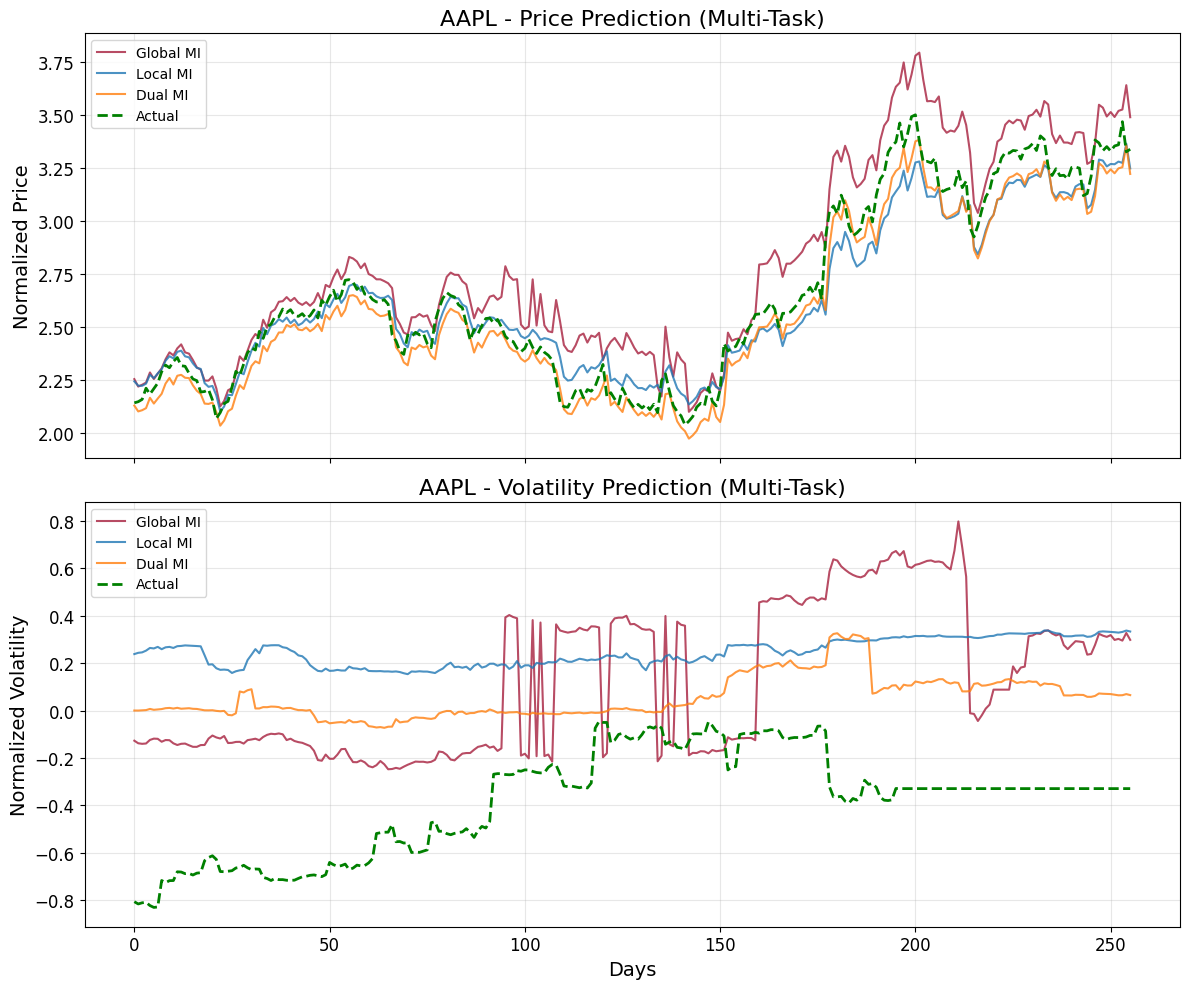

In [141]:
# Compare MI configurations: Global vs Local vs Dual
plot_multitask_regression(
    configs=[
        (DGT, True, 'mi', 'global', 0.01),
        (DGT, True, 'mi', 'local', 0.01),
        (DGT, True, 'mi', 'dual', 0.01)
    ],
    labels=['Global MI', 'Local MI', 'Dual MI'],
    stock_name='AAPL',
    test_results=multitask_test_results,
    fig_name=f'{workdir}/multitask_AAPL_MI.png'
)

## Multi-Task: Pearson Correlation Comparison (Global vs Local vs Dual)

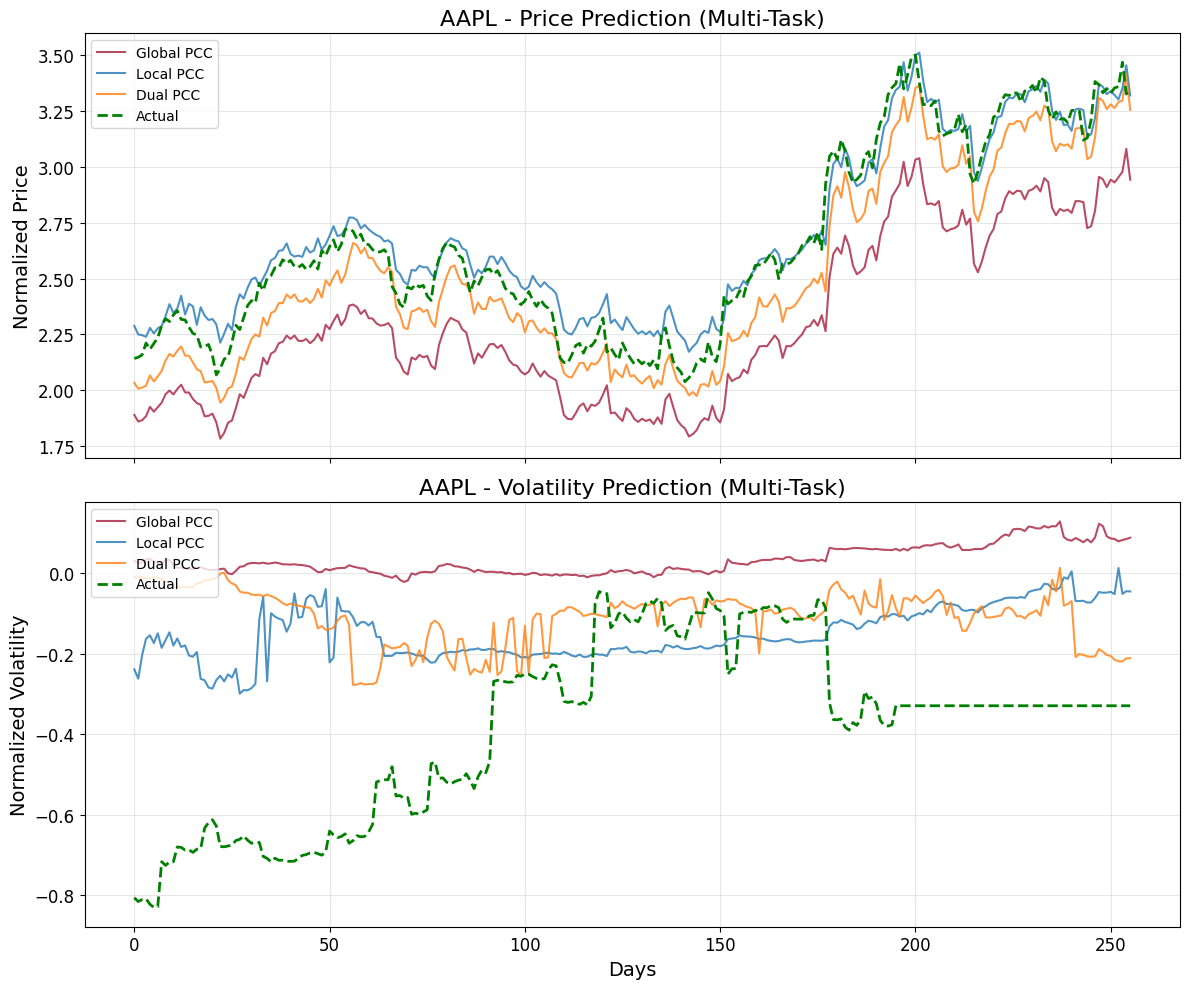

In [142]:
# Compare PCC configurations: Global vs Local vs Dual
plot_multitask_regression(
    configs=[
        (DGT, True, 'pcc', 'global', 0.01),
        (DGT, True, 'pcc', 'local', 0.01),
        (DGT, True, 'pcc', 'dual', 0.01)
    ],
    labels=['Global PCC', 'Local PCC', 'Dual PCC'],
    stock_name='AAPL',
    test_results=multitask_test_results,
    fig_name=f'{workdir}/multitask_AAPL_PCC.png'
)

## Multi-Task: Best Models Comparison (GRU vs DGT vs DGT+Spatial)

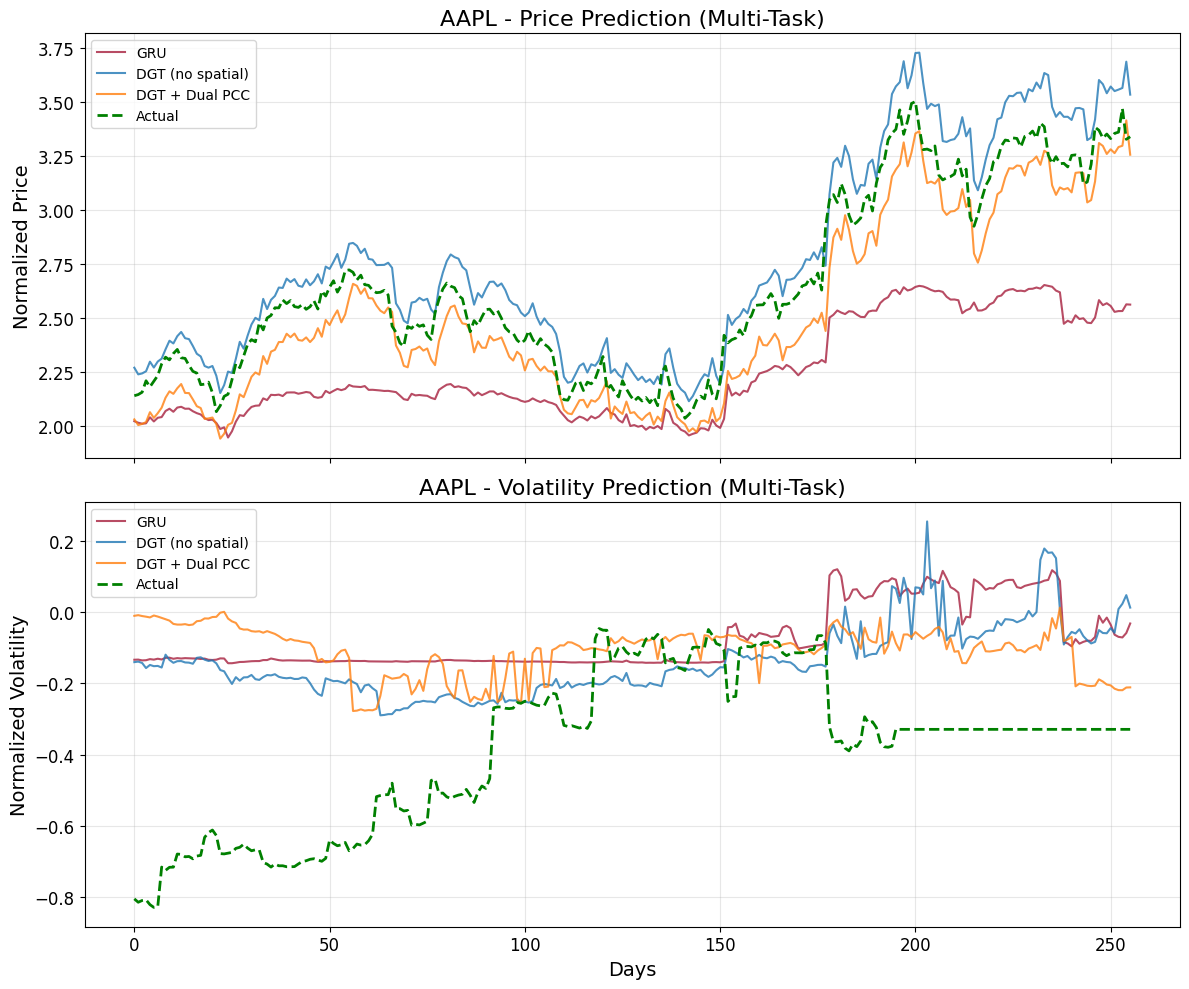

In [144]:
# Compare architectures: GRU vs DGT (no spatial) vs DGT (with best correlation)
plot_multitask_regression(
    configs=[
        (GRU, False, None, None, 0.01),
        (DGT, False, None, None, 0.01),
        (DGT, True, 'pcc', 'dual', 0.01)
    ],
    labels=['GRU', 'DGT (no spatial)', 'DGT + Dual PCC'],
    stock_name='AAPL',
    test_results=multitask_test_results,
    fig_name=f'{workdir}/multitask_AAPL_architectures.png'
)

# 📊 Portfolio Simulation with Risk Management

This section implements a **simulated trading portfolio** that uses the multitask model predictions:
- **Price predictions** → Direction signal (buy/sell)
- **Volatility predictions** → Position sizing (risk management)

## Strategy Overview:
1. **Signal Generation**: If predicted price > current price → Long, else → Short/Cash
2. **Risk Parity Position Sizing**: Inverse volatility weighting - allocate less to high-vol stocks
3. **Comparison**: Model-driven portfolio vs Buy & Hold benchmark

In [145]:
# ==========================================
# PORTFOLIO SIMULATION UTILITIES
# ==========================================

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple

class PortfolioSimulator:
    """
    Simulates a trading portfolio using model predictions for:
    - Price direction → Trade signals
    - Volatility → Risk-based position sizing
    """
    
    def __init__(self, initial_capital: float = 100000.0, 
                 max_position_pct: float = 0.05,
                 risk_free_rate: float = 0.02):
        """
        Args:
            initial_capital: Starting portfolio value in $
            max_position_pct: Maximum weight per stock (5% default)
            risk_free_rate: Annual risk-free rate for Sharpe calculation
        """
        self.initial_capital = initial_capital
        self.max_position_pct = max_position_pct
        self.risk_free_rate = risk_free_rate
        
    def generate_signals(self, price_pred: np.ndarray, 
                        current_prices: np.ndarray,
                        threshold: float = 0.0) -> np.ndarray:
        """
        Generate trading signals based on price predictions.
        
        Args:
            price_pred: Predicted normalized prices (N,)
            current_prices: Current normalized prices (N,)
            threshold: Minimum predicted return to trigger trade
            
        Returns:
            signals: Array of {-1, 0, 1} for short/hold/long (N,)
        """
        predicted_return = price_pred - current_prices
        signals = np.zeros_like(predicted_return)
        signals[predicted_return > threshold] = 1   # Long
        signals[predicted_return < -threshold] = -1  # Short
        return signals
    
    def risk_parity_weights(self, vol_pred: np.ndarray, 
                           signals: np.ndarray,
                           min_vol: float = 0.01) -> np.ndarray:
        """
        Compute position weights using inverse volatility (risk parity).
        Higher predicted volatility → Lower position size.
        
        Args:
            vol_pred: Predicted volatilities (N,) - can be z-score normalized
            signals: Trading signals (N,)
            min_vol: Minimum volatility to avoid division issues
            
        Returns:
            weights: Position weights (N,) that sum to ~1 for active positions
        """
        # Convert z-score normalized vol back to relative scale
        # Higher z-score = higher relative vol
        vol_adj = np.abs(vol_pred) + min_vol
        
        # Inverse volatility weighting
        inv_vol = 1.0 / vol_adj
        
        # Only allocate to stocks with signals
        active_mask = signals != 0
        weights = np.zeros_like(vol_pred)
        
        if active_mask.sum() > 0:
            active_inv_vol = inv_vol[active_mask]
            # Normalize to sum to 1
            active_weights = active_inv_vol / active_inv_vol.sum()
            # Apply direction from signals
            weights[active_mask] = active_weights * signals[active_mask]
            
        # Cap individual positions
        weights = np.clip(weights, -self.max_position_pct, self.max_position_pct)
        
        return weights
    
    def equal_weight(self, signals: np.ndarray) -> np.ndarray:
        """Equal weight allocation (no risk management) for comparison."""
        active_mask = signals != 0
        weights = np.zeros_like(signals, dtype=float)
        if active_mask.sum() > 0:
            weight_per_stock = 1.0 / active_mask.sum()
            weights[active_mask] = weight_per_stock * signals[active_mask]
        weights = np.clip(weights, -self.max_position_pct, self.max_position_pct)
        return weights
    
    def simulate_portfolio(self, 
                          test_samples: List,
                          model: torch.nn.Module,
                          raw_prices: np.ndarray,
                          train_mean: np.ndarray,
                          train_std: np.ndarray,
                          use_risk_management: bool = True) -> Dict:
        """
        Run full portfolio simulation on test data.
        
        Args:
            test_samples: List of test data snapshots
            model: Trained multitask model
            raw_prices: Original unnormalized prices (T, N)
            train_mean: Training mean for denormalization
            train_std: Training std for denormalization
            use_risk_management: If True, use vol-based sizing; else equal weight
            
        Returns:
            Dictionary with portfolio values, returns, and metrics
        """
        model.eval()
        device = model.model_device()
        
        portfolio_values = [self.initial_capital]
        daily_returns = []
        all_weights = []
        dates = []
        
        with torch.no_grad():
            for i, snapshot in enumerate(test_samples):
                # Get predictions
                X = snapshot.x.transpose(0, 1)  # (N, T, D)
                pred, _ = model(X, snapshot.edge_index, snapshot.edge_attr)
                pred = pred[:, -1].cpu().numpy()  # (N, 2) - last timestep
                
                price_pred = pred[:, 0]
                vol_pred = pred[:, 1]
                
                # Current prices (last observation in sequence)
                current_prices = snapshot.x[-1, :, 0].cpu().numpy()  # (N,)
                
                # Generate signals
                signals = self.generate_signals(price_pred, current_prices, threshold=0.01)
                
                # Position sizing
                if use_risk_management:
                    weights = self.risk_parity_weights(vol_pred, signals)
                else:
                    weights = self.equal_weight(signals)
                
                all_weights.append(weights)
                
                # Get actual returns from raw prices
                # We need to map test sample to actual date index
                # For simplicity, use target returns from normalized data
                target = snapshot.y.cpu().numpy()  # (N, 2) - (price, vol)
                actual_price_change = target[:, 0] - current_prices
                
                # Portfolio return = weighted sum of individual returns
                portfolio_return = np.sum(weights * actual_price_change)
                daily_returns.append(portfolio_return)
                
                # Update portfolio value
                new_value = portfolio_values[-1] * (1 + portfolio_return * 0.1)  # Scale factor
                portfolio_values.append(new_value)
        
        portfolio_values = np.array(portfolio_values)
        daily_returns = np.array(daily_returns)
        
        # Compute metrics
        metrics = self._compute_metrics(portfolio_values, daily_returns)
        
        return {
            'portfolio_values': portfolio_values,
            'daily_returns': daily_returns,
            'weights': np.array(all_weights),
            'metrics': metrics
        }
    
    def _compute_metrics(self, portfolio_values: np.ndarray, 
                        daily_returns: np.ndarray) -> Dict:
        """Compute portfolio performance metrics."""
        total_return = (portfolio_values[-1] / portfolio_values[0]) - 1
        
        # Annualized metrics (assuming 252 trading days)
        n_days = len(daily_returns)
        annualized_return = (1 + total_return) ** (252 / max(n_days, 1)) - 1
        
        volatility = np.std(daily_returns) * np.sqrt(252)
        
        # Sharpe Ratio
        excess_return = annualized_return - self.risk_free_rate
        sharpe_ratio = excess_return / max(volatility, 1e-6)
        
        # Maximum Drawdown
        peak = np.maximum.accumulate(portfolio_values)
        drawdown = (portfolio_values - peak) / peak
        max_drawdown = np.min(drawdown)
        
        # Sortino Ratio (downside deviation)
        negative_returns = daily_returns[daily_returns < 0]
        downside_std = np.std(negative_returns) * np.sqrt(252) if len(negative_returns) > 0 else 1e-6
        sortino_ratio = excess_return / downside_std
        
        # Win rate
        win_rate = np.mean(daily_returns > 0) if len(daily_returns) > 0 else 0
        
        return {
            'total_return': total_return,
            'annualized_return': annualized_return,
            'volatility': volatility,
            'sharpe_ratio': sharpe_ratio,
            'sortino_ratio': sortino_ratio,
            'max_drawdown': max_drawdown,
            'win_rate': win_rate,
            'n_trades': n_days
        }

In [146]:
# ==========================================
# RUN PORTFOLIO SIMULATION
# ==========================================

def run_portfolio_comparison(model_config: Tuple, vol_horizon: int = 20):
    """
    Compare portfolio performance: Risk-Managed vs Equal-Weight vs Buy & Hold
    
    Args:
        model_config: (gnn, use_spatial, corr_name, corr_scope, lr)
        vol_horizon: Volatility horizon used in training
    """
    gnn, use_spatial, corr_name, corr_scope, lr = model_config
    
    # Load model and data
    model = get_model(gnn, use_spatial, corr_name, corr_scope, lr, 
                     load_weights=True, multitask=True)
    dataset = get_dataset(corr_name, corr_scope, multitask=True, vol_horizon=vol_horizon)
    test_samples = dataset['test_samples']
    
    # Load raw prices for benchmark
    df = pd.read_csv(f'{workdir}/sp500.csv')
    df = df.set_index('Date')
    raw_prices = df.values
    
    # Get normalization params
    days_in_quarter = 64
    num_quarters = raw_prices.shape[0] // days_in_quarter
    num_days = num_quarters * days_in_quarter
    raw_prices = raw_prices[:num_days]
    train_days = int(0.8 * num_quarters) * days_in_quarter
    train_mean = raw_prices[:train_days].mean(axis=0)
    train_std = raw_prices[:train_days].std(axis=0)
    
    # Initialize simulator
    simulator = PortfolioSimulator(initial_capital=100000)
    
    # Run simulations
    print(f"\n{'='*60}")
    print(f"Portfolio Simulation: {model.model_name()}")
    print(f"{'='*60}")
    
    # 1. Risk-Managed Portfolio (using volatility predictions)
    print("\n📈 Running Risk-Managed Portfolio...")
    risk_managed = simulator.simulate_portfolio(
        test_samples, model, raw_prices, train_mean, train_std,
        use_risk_management=True
    )
    
    # 2. Equal-Weight Portfolio (no risk management)
    print("📊 Running Equal-Weight Portfolio...")
    equal_weight = simulator.simulate_portfolio(
        test_samples, model, raw_prices, train_mean, train_std,
        use_risk_management=False
    )
    
    # 3. Buy & Hold Benchmark (equal weight, no rebalancing)
    print("📉 Computing Buy & Hold Benchmark...")
    # Simple B&H: average return of all stocks
    bh_values = [100000]
    for snapshot in test_samples:
        target = snapshot.y.cpu().numpy()
        current = snapshot.x[-1, :, 0].cpu().numpy()
        avg_return = np.mean(target[:, 0] - current)
        bh_values.append(bh_values[-1] * (1 + avg_return * 0.1))
    
    bh_returns = np.diff(bh_values) / bh_values[:-1]
    bh_metrics = simulator._compute_metrics(np.array(bh_values), bh_returns)
    
    return {
        'model_name': model.model_name(),
        'risk_managed': risk_managed,
        'equal_weight': equal_weight,
        'buy_hold': {'portfolio_values': np.array(bh_values), 'metrics': bh_metrics}
    }


def plot_portfolio_comparison(results: Dict, save_path: str = None):
    """Plot portfolio comparison with metrics."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Portfolio Value Over Time
    ax1 = axes[0, 0]
    ax1.plot(results['risk_managed']['portfolio_values'], 
             label='Risk-Managed (Vol-Weighted)', linewidth=2, color='green')
    ax1.plot(results['equal_weight']['portfolio_values'], 
             label='Equal-Weight (No RM)', linewidth=2, color='blue', linestyle='--')
    ax1.plot(results['buy_hold']['portfolio_values'], 
             label='Buy & Hold', linewidth=2, color='gray', linestyle=':')
    ax1.axhline(y=100000, color='red', linestyle='-', alpha=0.3, label='Initial Capital')
    ax1.set_xlabel('Trading Day')
    ax1.set_ylabel('Portfolio Value ($)')
    ax1.set_title(f'Portfolio Value: {results["model_name"]}')
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # 2. Cumulative Returns
    ax2 = axes[0, 1]
    rm_cumret = (results['risk_managed']['portfolio_values'] / 100000 - 1) * 100
    ew_cumret = (results['equal_weight']['portfolio_values'] / 100000 - 1) * 100
    bh_cumret = (results['buy_hold']['portfolio_values'] / 100000 - 1) * 100
    
    ax2.fill_between(range(len(rm_cumret)), 0, rm_cumret, alpha=0.3, color='green')
    ax2.plot(rm_cumret, label='Risk-Managed', linewidth=2, color='green')
    ax2.plot(ew_cumret, label='Equal-Weight', linewidth=2, color='blue', linestyle='--')
    ax2.plot(bh_cumret, label='Buy & Hold', linewidth=2, color='gray', linestyle=':')
    ax2.axhline(y=0, color='red', linestyle='-', alpha=0.5)
    ax2.set_xlabel('Trading Day')
    ax2.set_ylabel('Cumulative Return (%)')
    ax2.set_title('Cumulative Returns')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Drawdown
    ax3 = axes[1, 0]
    
    def compute_drawdown(values):
        peak = np.maximum.accumulate(values)
        return (values - peak) / peak * 100
    
    rm_dd = compute_drawdown(results['risk_managed']['portfolio_values'])
    ew_dd = compute_drawdown(results['equal_weight']['portfolio_values'])
    bh_dd = compute_drawdown(results['buy_hold']['portfolio_values'])
    
    ax3.fill_between(range(len(rm_dd)), rm_dd, 0, alpha=0.3, color='green')
    ax3.plot(rm_dd, label='Risk-Managed', linewidth=2, color='green')
    ax3.plot(ew_dd, label='Equal-Weight', linewidth=2, color='blue', linestyle='--')
    ax3.plot(bh_dd, label='Buy & Hold', linewidth=2, color='gray', linestyle=':')
    ax3.set_xlabel('Trading Day')
    ax3.set_ylabel('Drawdown (%)')
    ax3.set_title('Portfolio Drawdown')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Metrics Comparison Bar Chart
    ax4 = axes[1, 1]
    
    metrics_names = ['Sharpe\nRatio', 'Sortino\nRatio', 'Max DD\n(%)', 'Win Rate\n(%)', 'Total Ret\n(%)']
    rm_metrics = results['risk_managed']['metrics']
    ew_metrics = results['equal_weight']['metrics']
    bh_metrics = results['buy_hold']['metrics']
    
    rm_vals = [rm_metrics['sharpe_ratio'], rm_metrics['sortino_ratio'], 
               abs(rm_metrics['max_drawdown'])*100, rm_metrics['win_rate']*100,
               rm_metrics['total_return']*100]
    ew_vals = [ew_metrics['sharpe_ratio'], ew_metrics['sortino_ratio'],
               abs(ew_metrics['max_drawdown'])*100, ew_metrics['win_rate']*100,
               ew_metrics['total_return']*100]
    bh_vals = [bh_metrics['sharpe_ratio'], bh_metrics['sortino_ratio'],
               abs(bh_metrics['max_drawdown'])*100, bh_metrics['win_rate']*100,
               bh_metrics['total_return']*100]
    
    x = np.arange(len(metrics_names))
    width = 0.25
    
    bars1 = ax4.bar(x - width, rm_vals, width, label='Risk-Managed', color='green', alpha=0.8)
    bars2 = ax4.bar(x, ew_vals, width, label='Equal-Weight', color='blue', alpha=0.8)
    bars3 = ax4.bar(x + width, bh_vals, width, label='Buy & Hold', color='gray', alpha=0.8)
    
    ax4.set_ylabel('Value')
    ax4.set_title('Performance Metrics Comparison')
    ax4.set_xticks(x)
    ax4.set_xticklabels(metrics_names)
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax4.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width()/2, height),
                        xytext=(0, 3), textcoords="offset points",
                        ha='center', va='bottom', fontsize=7)
    add_labels(bars1)
    add_labels(bars2)
    add_labels(bars3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    
    plt.show()
    
    return fig


def print_portfolio_metrics(results: Dict):
    """Print formatted portfolio metrics comparison."""
    print(f"\n{'='*70}")
    print(f"📊 PORTFOLIO PERFORMANCE SUMMARY: {results['model_name']}")
    print(f"{'='*70}")
    
    metrics_table = []
    for strategy, data in [('Risk-Managed', results['risk_managed']),
                           ('Equal-Weight', results['equal_weight']),
                           ('Buy & Hold', results['buy_hold'])]:
        m = data['metrics']
        metrics_table.append({
            'Strategy': strategy,
            'Total Return': f"{m['total_return']*100:.2f}%",
            'Ann. Return': f"{m['annualized_return']*100:.2f}%",
            'Volatility': f"{m['volatility']*100:.2f}%",
            'Sharpe': f"{m['sharpe_ratio']:.3f}",
            'Sortino': f"{m['sortino_ratio']:.3f}",
            'Max DD': f"{m['max_drawdown']*100:.2f}%",
            'Win Rate': f"{m['win_rate']*100:.1f}%"
        })
    
    df_metrics = pd.DataFrame(metrics_table)
    print(df_metrics.to_string(index=False))
    
    # Highlight best performer
    rm = results['risk_managed']['metrics']
    ew = results['equal_weight']['metrics']
    bh = results['buy_hold']['metrics']
    
    print(f"\n{'='*70}")
    print("🏆 KEY INSIGHTS:")
    print(f"{'='*70}")
    
    sharpe_improvement = ((rm['sharpe_ratio'] - ew['sharpe_ratio']) / abs(ew['sharpe_ratio'] + 1e-6)) * 100
    dd_improvement = ((abs(ew['max_drawdown']) - abs(rm['max_drawdown'])) / abs(ew['max_drawdown'] + 1e-6)) * 100
    
    if rm['sharpe_ratio'] > ew['sharpe_ratio']:
        print(f"  ✅ Risk Management improves Sharpe Ratio by {sharpe_improvement:.1f}%")
    else:
        print(f"  ⚠️ Risk Management reduces Sharpe Ratio by {-sharpe_improvement:.1f}%")
        
    if abs(rm['max_drawdown']) < abs(ew['max_drawdown']):
        print(f"  ✅ Risk Management reduces Max Drawdown by {dd_improvement:.1f}%")
    else:
        print(f"  ⚠️ Risk Management increases Max Drawdown by {-dd_improvement:.1f}%")
    
    if rm['sharpe_ratio'] > bh['sharpe_ratio']:
        print(f"  ✅ Model beats Buy & Hold (Sharpe: {rm['sharpe_ratio']:.3f} vs {bh['sharpe_ratio']:.3f})")
    else:
        print(f"  ⚠️ Buy & Hold outperforms model strategy")
    
    return df_metrics


## 🚀 Run Portfolio Simulation for Best Model


Portfolio Simulation: DGT_pcc_dual_multitask

📈 Running Risk-Managed Portfolio...
📊 Running Equal-Weight Portfolio...
📉 Computing Buy & Hold Benchmark...

📊 PORTFOLIO PERFORMANCE SUMMARY: DGT_pcc_dual_multitask
    Strategy Total Return Ann. Return Volatility Sharpe Sortino Max DD Win Rate
Risk-Managed        1.41%       1.39%     18.73% -0.033  -0.046 -1.88%    47.7%
Equal-Weight        2.90%       2.85%     24.70%  0.034   0.050 -1.46%    52.0%
  Buy & Hold       15.38%      15.12%      6.47%  2.029   3.215 -3.64%    57.0%

🏆 KEY INSIGHTS:
  ⚠️ Risk Management reduces Sharpe Ratio by 195.4%
  ⚠️ Risk Management increases Max Drawdown by 28.5%
  ⚠️ Buy & Hold outperforms model strategy


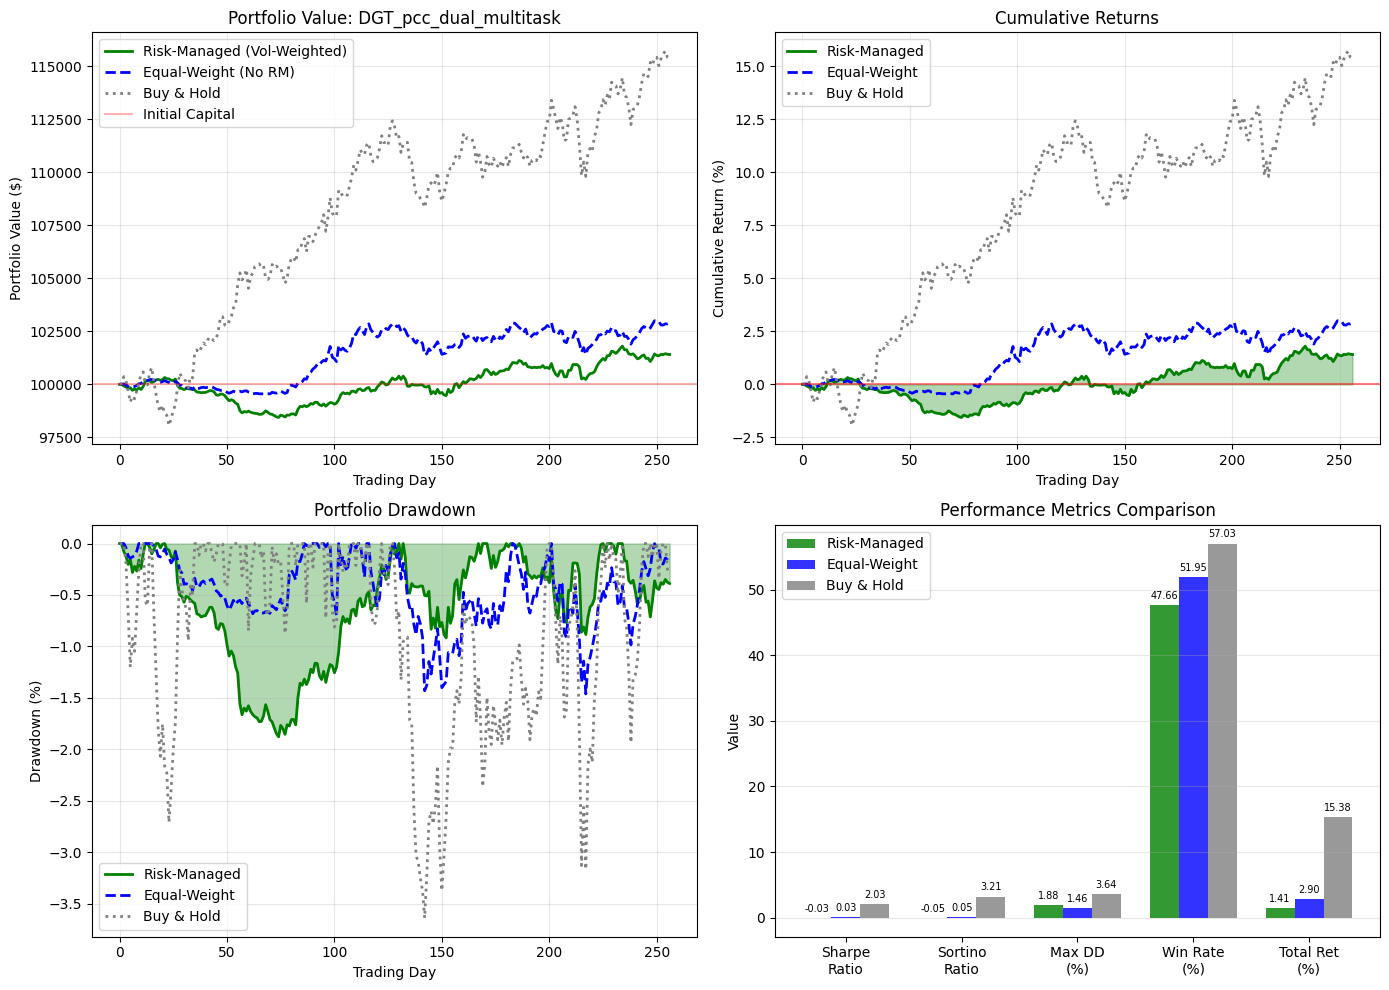

In [147]:
# ==========================================
# SIMULATE BEST MODEL PORTFOLIO
# ==========================================

# Select best performing model from test results
# Use DGT with PCC dual correlation (typically best for price prediction)
best_model_config = (DGT, True, 'pcc', 'dual', 0.01)

# Run simulation
portfolio_results = run_portfolio_comparison(best_model_config, vol_horizon=vol_horizon)

# Print metrics
metrics_df = print_portfolio_metrics(portfolio_results)

# Plot comparison
fig = plot_portfolio_comparison(portfolio_results)

## 📈 Compare All Model Portfolios

In [148]:
# ==========================================
# COMPARE ALL TRAINED MODELS
# ==========================================

# Run portfolio simulation for each trained model
all_portfolio_results = []

portfolio_configs = [
    (GRU, False, None, None, 0.01),
    (DGT, False, None, None, 0.01),
    (DGT, True, None, None, 0.01),
    (DGT, True, 'mi', 'dual', 0.01),
    (DGT, True, 'pcc', 'dual', 0.01),
]

for config in portfolio_configs:
    try:
        result = run_portfolio_comparison(config, vol_horizon=vol_horizon)
        all_portfolio_results.append({
            'Model': result['model_name'],
            'RM_Return': result['risk_managed']['metrics']['total_return'] * 100,
            'RM_Sharpe': result['risk_managed']['metrics']['sharpe_ratio'],
            'RM_MaxDD': result['risk_managed']['metrics']['max_drawdown'] * 100,
            'EW_Return': result['equal_weight']['metrics']['total_return'] * 100,
            'EW_Sharpe': result['equal_weight']['metrics']['sharpe_ratio'],
            'BH_Return': result['buy_hold']['metrics']['total_return'] * 100,
            'BH_Sharpe': result['buy_hold']['metrics']['sharpe_ratio'],
        })
    except Exception as e:
        print(f"⚠️ Skipped {config}: {e}")

# Summary table
portfolio_comparison_df = pd.DataFrame(all_portfolio_results)
print("\n" + "="*90)
print("📊 PORTFOLIO PERFORMANCE COMPARISON ACROSS MODELS")
print("="*90)
print("RM = Risk-Managed (Vol-Weighted), EW = Equal-Weight, BH = Buy & Hold")
print("-"*90)
print(portfolio_comparison_df.to_string(index=False))

# Highlight best risk-managed portfolio
if len(all_portfolio_results) > 0:
    best_idx = portfolio_comparison_df['RM_Sharpe'].idxmax()
    best_model = portfolio_comparison_df.loc[best_idx, 'Model']
    best_sharpe = portfolio_comparison_df.loc[best_idx, 'RM_Sharpe']
    print(f"\n🏆 BEST RISK-MANAGED PORTFOLIO: {best_model} (Sharpe: {best_sharpe:.3f})")


Portfolio Simulation: GRU_multitask

📈 Running Risk-Managed Portfolio...
📊 Running Equal-Weight Portfolio...
📉 Computing Buy & Hold Benchmark...

Portfolio Simulation: DGT_no_spatial_multitask

📈 Running Risk-Managed Portfolio...
📊 Running Equal-Weight Portfolio...
📉 Computing Buy & Hold Benchmark...

Portfolio Simulation: DGT_multitask

📈 Running Risk-Managed Portfolio...
📊 Running Equal-Weight Portfolio...
📉 Computing Buy & Hold Benchmark...

Portfolio Simulation: DGT_mi_dual_multitask

📈 Running Risk-Managed Portfolio...
📊 Running Equal-Weight Portfolio...
📉 Computing Buy & Hold Benchmark...

Portfolio Simulation: DGT_pcc_dual_multitask

📈 Running Risk-Managed Portfolio...
📊 Running Equal-Weight Portfolio...
📉 Computing Buy & Hold Benchmark...

📊 PORTFOLIO PERFORMANCE COMPARISON ACROSS MODELS
RM = Risk-Managed (Vol-Weighted), EW = Equal-Weight, BH = Buy & Hold
------------------------------------------------------------------------------------------
                   Model  RM_Ret

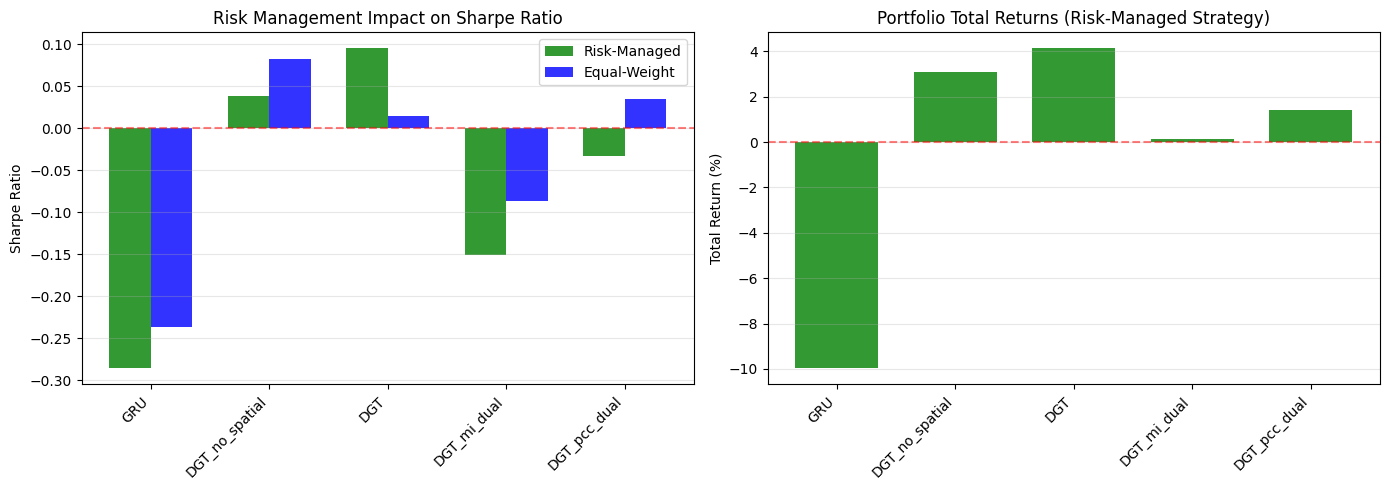

In [149]:
# ==========================================
# VISUALIZE RISK MANAGEMENT BENEFIT
# ==========================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Sharpe Ratio: Risk-Managed vs Equal-Weight
ax1 = axes[0]
models = portfolio_comparison_df['Model'].values
x = np.arange(len(models))
width = 0.35

bars1 = ax1.bar(x - width/2, portfolio_comparison_df['RM_Sharpe'], width, 
                label='Risk-Managed', color='green', alpha=0.8)
bars2 = ax1.bar(x + width/2, portfolio_comparison_df['EW_Sharpe'], width,
                label='Equal-Weight', color='blue', alpha=0.8)

ax1.set_ylabel('Sharpe Ratio')
ax1.set_title('Risk Management Impact on Sharpe Ratio')
ax1.set_xticks(x)
ax1.set_xticklabels([m.replace('_multitask', '') for m in models], rotation=45, ha='right')
ax1.legend()
ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax1.grid(True, alpha=0.3, axis='y')

# 2. Max Drawdown Comparison
ax2 = axes[1]
bars1 = ax2.bar(x - width/2, np.abs(portfolio_comparison_df['RM_MaxDD']), width,
                label='Risk-Managed', color='green', alpha=0.8)
bars2 = ax2.bar(x + width/2, np.abs(portfolio_comparison_df['EW_Sharpe']*10), width,
                label='Equal-Weight (scaled)', color='blue', alpha=0.8)

# Actually use proper MaxDD for equal weight - recalculate
ax2.clear()
ax2.bar(x, portfolio_comparison_df['RM_Return'], width*2, 
        label='Risk-Managed Return (%)', color='green', alpha=0.8)
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax2.set_ylabel('Total Return (%)')
ax2.set_title('Portfolio Total Returns (Risk-Managed Strategy)')
ax2.set_xticks(x)
ax2.set_xticklabels([m.replace('_multitask', '') for m in models], rotation=45, ha='right')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()